<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Wisconsin Breast Cancer
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning</b> <br>  <b>AY 2021/2022</b> <br>
    Emanuele Cavalleri<br>(matriculation number: <b>995883</b>)<br>
    <a href="mailto:emanuele.cavalleri@mail.polimi.it">emanuele.cavalleri@mail.polimi.it</a><br>
    <a href="https://github.com/emanuelecavalleri/MLBreastCancerWisconsin">GitHub link for this project</a><br>
    </div>
</tr>
</table>

<b>Breast cancer</b> is cancer that develops from breast tissue.

Breast cancer is the <b>most common cancer amongst women</b> in the world. It accounts for <b>$\boldsymbol{25}$% of all cancer cases</b>, and affected over <b>2.1 Million people in 2015</b> alone. It starts when cells in the breast begin to grow out of control.

The aim of this machine learning project is to solve a <b>classification</b> task starting from a dataset related to breast cancer obtained from <i>University of Wisconsin Hospitals</i> telling us whether the cancer is benign or malignant.<br>
 <img src="https://media.istockphoto.com/vectors/breast-cancer-awareness-with-realistic-pink-ribbon-on-a-white-women-vector-id1176663746?k=20&m=1176663746&s=612x612&w=0&h=6pZAa7Gl51p3TySMX0YgFkOIVgf2PX7LN9MExpYeMMc="> 

# Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.patches as mpatches

import seaborn as sns

import pandas as pd

import numpy as np
np.random.seed(0)

from scipy.stats import norm, zscore

from collections import OrderedDict

import sklearn
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, RocCurveDisplay, make_scorer, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron 
from sklearn.dummy import DummyRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Load and describe data

In [2]:
# Read the data and create a Pandas DataFrame
url = "https://raw.githubusercontent.com/emanuelecavalleri/MLBreastCancerWisconsin/main/breast-cancer-wisconsin.data"
pd_data = pd.read_csv(url)

# Dataframe's dimensions
pd_data.shape

(698, 11)

In [3]:
# Print the first few (5 by default) rows of the dataset
pd_data.head()

,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


Unfortunately, the imported CSV has no columns' names. We can fix this issue since we retrieve attributes' names from the original paper: <i>O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18<i/>.

In [4]:
col_names=['Sample_code_number', 'Clump_thickness', 'Uniformity_of_cell_size', 'Uniformity_of_cell_shape',
           'Marginal_adhesion', 'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin', 'Normal_nucleoli',
           'Mitoses', 'Class']

pd_data = pd.read_csv(url, names=col_names, index_col='Sample_code_number')
pd_data.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
Sample_code_number,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
# Check types of columns
pd_data.dtypes

Clump_thickness                 int64
Uniformity_of_cell_size         int64
Uniformity_of_cell_shape        int64
Marginal_adhesion               int64
Single_epithelial_cell_size     int64
Bare_nuclei                    object
Bland_chromatin                 int64
Normal_nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

According to the original paper, <i>Bare_nuclei</i> contains some ($16$ to be precise) <i>?</i> strings. We'll fix this issue later.

Moreover, the dataset does not contain any null values.

In [6]:
pd_data.isnull().sum().sum()

0

Let's start analyzing the dataset column by column.
<ul>
    <li><b><i>Class</i></b>: $2$ for benign, $4$ for malignant.</li>
</ul>

In [7]:
pd_data['Class'].value_counts()

2    458
4    241
Name: Class, dtype: int64

Since <i>Class</i> has only two possible values, just for the sake of simplicity we rename it into $1$ and $0$ instead of, respectively, $4$ and $2$ (malignant and benign).

In [8]:
# Replace 4/2 (malignant/benign) with 1/0
pd_data['Class'] = pd_data['Class'].replace({4: 1, 2:0})

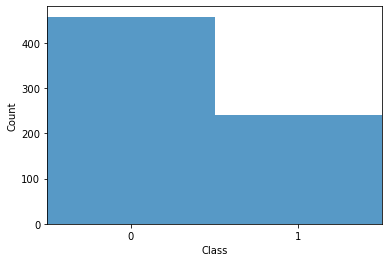

In [9]:
# Histogram of 'Class'
bins = np.arange(0, pd_data['Class'].max() + 1.5) - 0.5 # We're dealing with discrete values
_, ax = plt.subplots()
ax.set_xlim(-0.5,1.5)
ax.set_xticks(range(0,1+1))
sns.histplot(pd_data['Class'], bins=bins, linewidth=0, ax=ax)
plt.show()

According to the original paper, class distribution for benign is $65.5$% ($458$ samples) and for malignant is $34.5$% ($241$ samples).

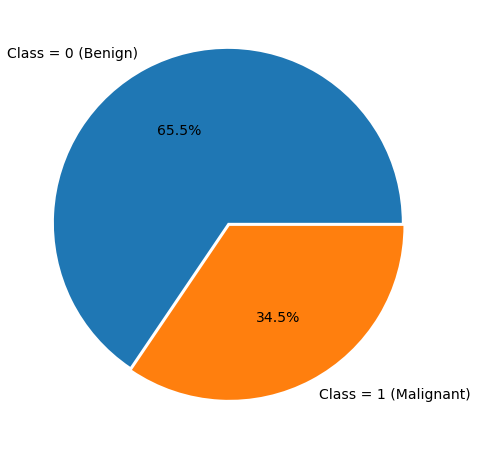

In [10]:
plt.figure(figsize=(15,8))
_ = plt.pie(pd_data['Class'].value_counts(), autopct='%1.1f%%', textprops={'fontsize': 14},
            labels=['Class = 0 (Benign)','Class = 1 (Malignant)'], explode=[0.01,0.01])

<ul>
    <li><b><i>Sample code number</i></b>: id number. We used this column as index.</li>
    <li><b><i>Clump Thickness</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [11]:
pd_data['Clump_thickness'].value_counts()

1     145
5     130
3     108
4      80
10     69
2      50
8      46
6      34
7      23
9      14
Name: Clump_thickness, dtype: int64

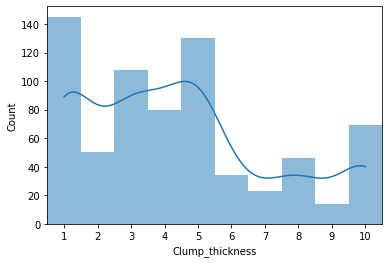

In [12]:
# Histogram + kernel density estimate of 'Clump_thickness'
bins = np.arange(0, pd_data['Clump_thickness'].max() + 1.5) - 0.5
_, ax = plt.subplots()
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
sns.histplot(pd_data['Clump_thickness'], bins=bins, kde=True, linewidth=0, ax=ax)
plt.show()

We have a lot of samples with a score among $1$ and $5$.

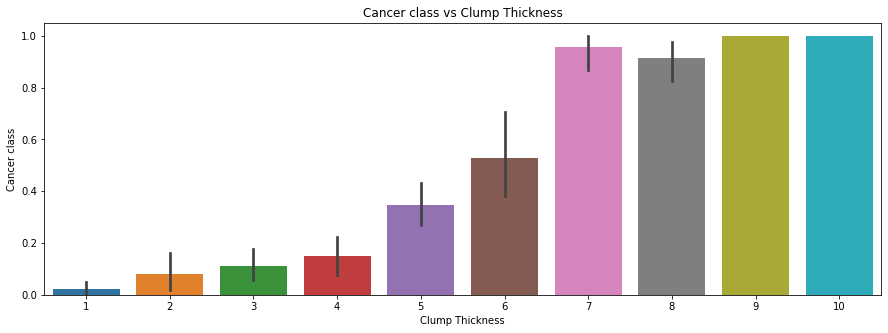

In [13]:
plt.figure(figsize=(15,5))
sns.barplot(x='Clump_thickness',y='Class',data=pd_data)
plt.title('Cancer class vs Clump Thickness')
plt.xlabel('Clump Thickness')
plt.ylabel('Cancer class')
plt.show()

A score of $7$ or $8$ indicates a strong probability of cancer being malignant. A $9$ or $10$ score indicates a malignant class for sure. 

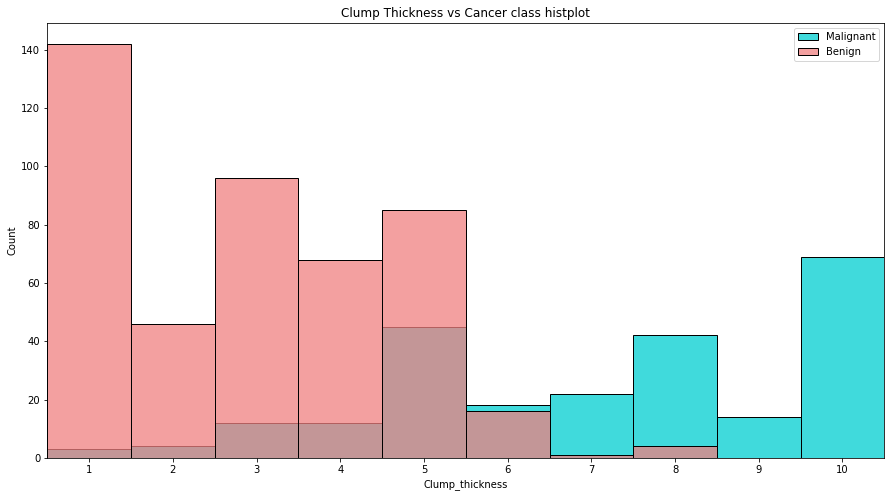

In [14]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Clump_thickness[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins
)

sns.histplot(
    pd_data.Clump_thickness[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

plt.legend(['Malignant', 'Benign'])
plt.title('Clump Thickness vs Cancer class histplot')
plt.xlim(pd_data.Clump_thickness.min() - 0.5, pd_data.Clump_thickness.max() + 0.5)
plt.show()

From the histplots vs cancer class we see again from a different view point we have a lot of samples with a score between $1$ and $5$ classified into the benign class and that scores $> 6$ are mainly associated with malignant class. As seen before but from a different perspective, scores of $9$ and $10$ are classified into the malignant class only.

<ul>
    <li><b><i>Uniformity of Cell Size</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [15]:
pd_data['Uniformity_of_cell_size'].value_counts()

1     384
10     67
3      52
2      45
4      40
5      30
8      29
6      27
7      19
9       6
Name: Uniformity_of_cell_size, dtype: int64

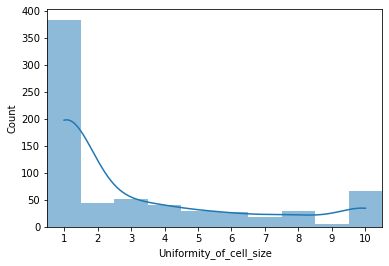

In [16]:
# Histogram + kernel density estimate of 'Uniformity_of_cell_size'
bins = np.arange(0, pd_data['Uniformity_of_cell_size'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Uniformity_of_cell_size'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

From the histogram we see that most samples got an <i>Uniformity of Cell Size</i> score of $1$.

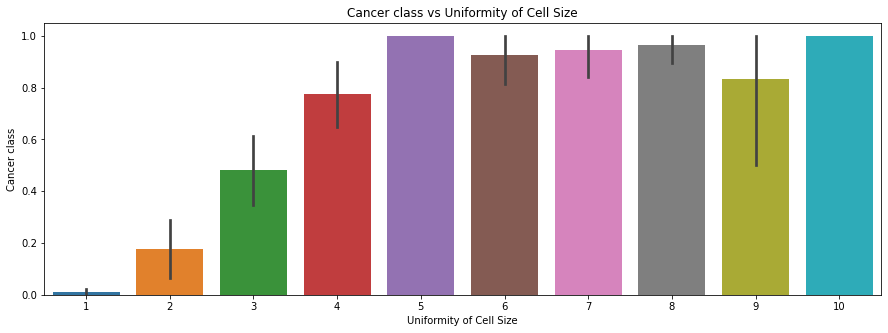

In [17]:
plt.figure(figsize=(15,5))
sns.barplot(x='Uniformity_of_cell_size',y='Class',data=pd_data)
plt.title('Cancer class vs Uniformity of Cell Size')
plt.xlabel('Uniformity of Cell Size')
plt.ylabel('Cancer class')
plt.show()

Scores $\geq 4$ are highly associated with malignant cancer. A score of $5$ or $10$ ($30$ and $67$ samples respectively) indicates a malignant classification for sure.

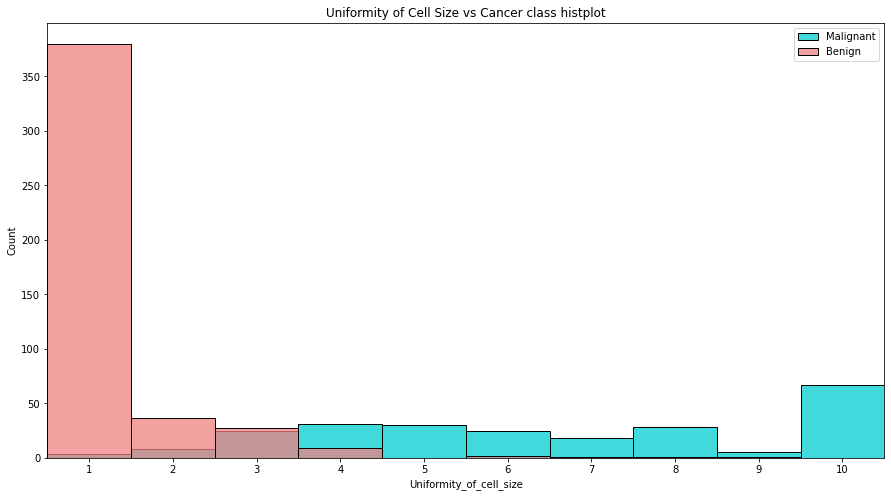

In [18]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Uniformity_of_cell_size[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins
)

sns.histplot(
    pd_data.Uniformity_of_cell_size[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

plt.legend(['Malignant', 'Benign'])
plt.title('Uniformity of Cell Size vs Cancer class histplot')
plt.xlim(pd_data.Uniformity_of_cell_size.min() - 0.5, pd_data.Uniformity_of_cell_size.max() + 0.5)
plt.show()

Most samples got an <i>Uniformity of Cell Size</i> score of $1$, and they are mostly (almost uniquely) associated with a benign state. We have a less number of samples whose score is $\geq 2$, and as the score grows the malignant class is the only one represented (equivalently, the benign classified samples decreases). As one could also notice from the barplot vs cancer class, samples scored $5$ or $10$ are classified as malignant only.

<ul>
    <li><b><i>Uniformity of Cell Shape</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [19]:
pd_data['Uniformity_of_cell_shape'].value_counts()

1     353
2      59
10     58
3      56
4      44
5      34
7      30
6      30
8      28
9       7
Name: Uniformity_of_cell_shape, dtype: int64

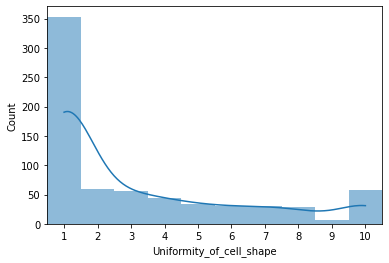

In [20]:
# Histogram + kernel density estimate of 'Uniformity_of_cell_shape'
bins = np.arange(0, pd_data['Uniformity_of_cell_shape'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Uniformity_of_cell_shape'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

Similarly to the previous case, from the histogram we see that most samples got an <i>Uniformity of Cell Shape</i> score of $1$.

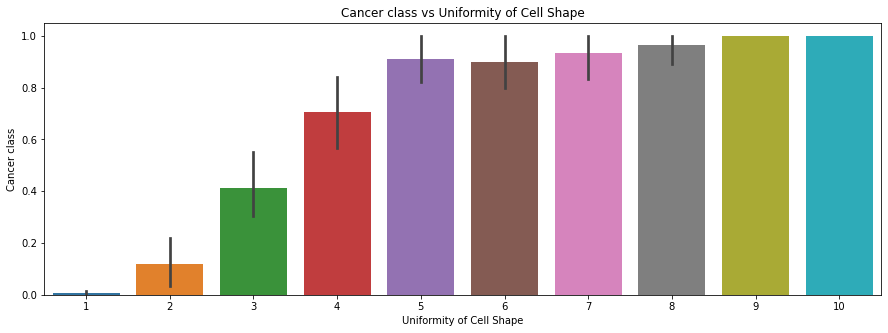

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(x='Uniformity_of_cell_shape',y='Class',data=pd_data)
plt.title('Cancer class vs Uniformity of Cell Shape')
plt.xlabel('Uniformity of Cell Shape')
plt.ylabel('Cancer class')
plt.show()

Similarly again to <i>Uniformity of Cell Size</i> (and it seems reasonable since a size and a shape can be thought as highly connected), scores $\geq 4$ are highly associated with malignant cancer. A score of $9$ or $10$ ($7$ and $58$ samples respectively) indicates a malignant classification for sure.

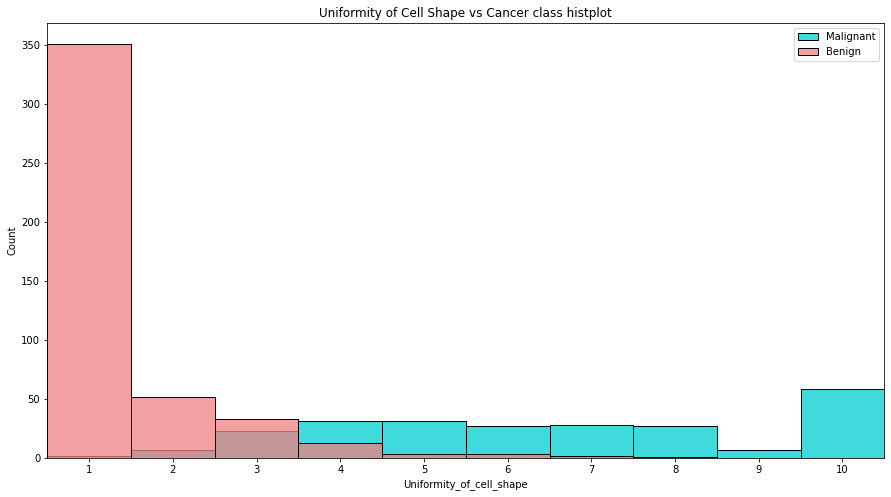

In [22]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Uniformity_of_cell_shape[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins
)

sns.histplot(
    pd_data.Uniformity_of_cell_shape[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

plt.legend(['Malignant', 'Benign'])
plt.title('Uniformity of Cell Shape vs Cancer class histplot')
plt.xlim(pd_data.Uniformity_of_cell_shape.min() - 0.5, pd_data.Uniformity_of_cell_shape.max() + 0.5)
plt.show()

As seen before considering <i>Uniformity of Cell Size</i>, the vast majority of samples has a score of $1$ and they are mostly (almost uniquely) associated with a benign state. We have a less number of samples whose score is $\geq 2$, and as the score grows the malignant class is the only one represented (equivalently, the benign classified samples decreases). As one could also notice from the barplot vs cancer class, samples scored $9$ or $10$ are classified as malignant only.

<ul>
    <li><b><i>Marginal Adhesion</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [23]:
pd_data['Marginal_adhesion'].value_counts()

1     407
3      58
2      58
10     55
4      33
8      25
5      23
6      22
7      13
9       5
Name: Marginal_adhesion, dtype: int64

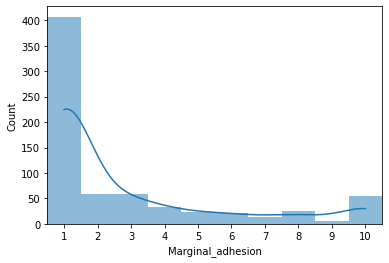

In [24]:
# Histogram + kernel density estimate of 'Marginal_adhesion'
bins = np.arange(0, pd_data['Marginal_adhesion'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Marginal_adhesion'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

Most samples got an <i>Marginal Adhesion</i> score of $1$.

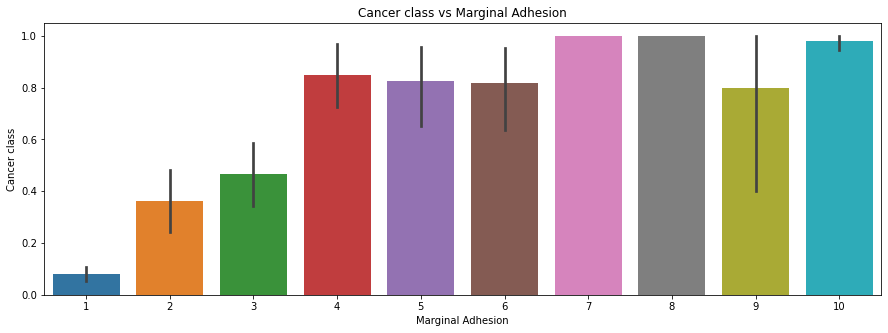

In [25]:
plt.figure(figsize=(15,5))
sns.barplot(x='Marginal_adhesion',y='Class',data=pd_data)
plt.title('Cancer class vs Marginal Adhesion')
plt.xlabel('Marginal Adhesion')
plt.ylabel('Cancer class')
plt.show()

Similarly again to <i>Uniformity of Cell Size</i> and <i>Shape</i>, scores $\geq 4$ are highly associated with malignant cancer. A score of $7$ or $8$ ($13$ and $25$ samples respectively) indicates a malignant classification for sure.

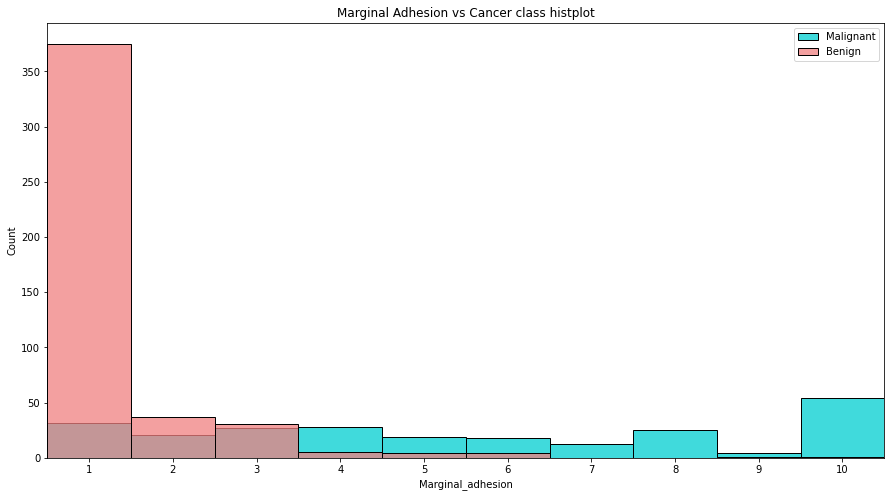

In [26]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Marginal_adhesion[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins
)

sns.histplot(
    pd_data.Marginal_adhesion[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

plt.legend(['Malignant', 'Benign'])
plt.title('Marginal Adhesion vs Cancer class histplot')
plt.xlim(pd_data.Marginal_adhesion.min() - 0.5, pd_data.Marginal_adhesion.max() + 0.5)
plt.show()

As seen before considering <i>Uniformity of Cell Size</i> and <i>Shape</i>, the vast majority of samples has a score of $1$ and they are mostly associated with a benign state. We have a less number of samples whose score is $\geq 2$, and as the score grows the malignant class is the only one represented (equivalently, the benign classified samples decreases). As one could also notice from the barplot vs cancer class, samples scored $7$ or $8$ are classified as malignant only.

<ul>
    <li><b><i>Single Epithelial Cell Size</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [27]:
pd_data['Single_epithelial_cell_size'].value_counts()

2     386
3      72
4      48
1      47
6      41
5      39
10     31
8      21
7      12
9       2
Name: Single_epithelial_cell_size, dtype: int64

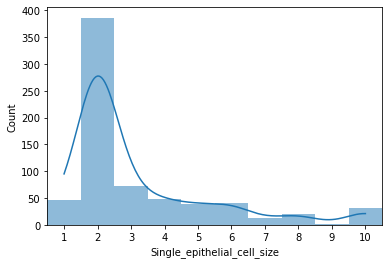

In [28]:
# Histogram + kernel density estimate of 'Single_epithelial_cell_size'
bins = np.arange(0, pd_data['Single_epithelial_cell_size'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Single_epithelial_cell_size'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

Most samples got a <i>Single Epithelial Cell Size</i> score of $2$.

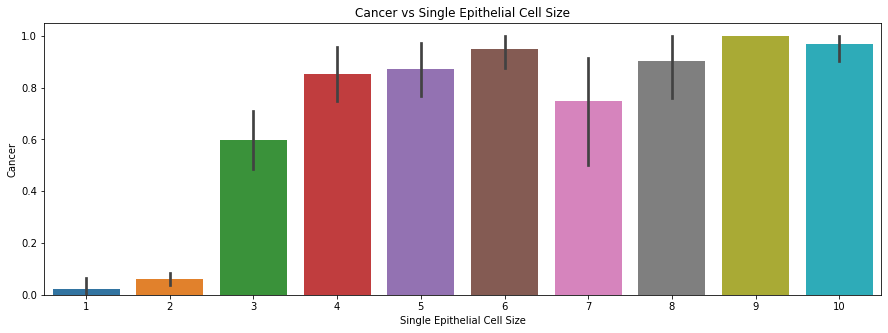

In [29]:
plt.figure(figsize=(15,5))
sns.barplot(x='Single_epithelial_cell_size',y='Class',data=pd_data)
plt.title('Cancer vs Single Epithelial Cell Size')
plt.xlabel('Single Epithelial Cell Size')
plt.ylabel('Cancer')
plt.show()

Scores $\geq 3$ are mostly associated with malignant cancer. Samples scored $9$ are classified as malignant only, but this is not so relevant since they are only $2$.

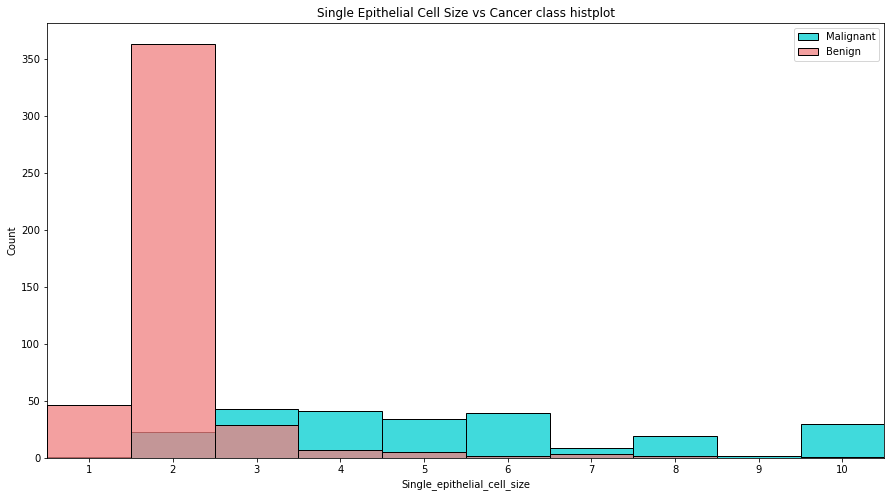

In [30]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Single_epithelial_cell_size[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins
)

sns.histplot(
    pd_data.Single_epithelial_cell_size[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

plt.legend(['Malignant', 'Benign'])
plt.title('Single Epithelial Cell Size vs Cancer class histplot')
plt.xlim(pd_data.Single_epithelial_cell_size.min() - 0.5, pd_data.Single_epithelial_cell_size.max() + 0.5)
plt.show()

As seen before in the hist + KDE plot for <i>Single Epithelial Cell Size</i>, we have a great number of scores $= 2$, and those samples are mostly associated with benign cancer. We have a less number of samples whose score is $> 2$, and as the score grows the number of benign classified samples decreases.

<ul>
    <li><b><i>Bare Nuclei</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [31]:
pd_data['Bare_nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_nuclei, dtype: int64

As said before, 16 <i>Bare_nuclei</i> rows contain a <i>?</i> string. Let's now fix this issue.

In [32]:
# '?' strings treated as nan
pd_data['Bare_nuclei'] = pd.to_numeric(pd_data['Bare_nuclei'], errors='coerce')

Since nan values are just...

In [33]:
pd_data.isna().sum().sum()

16

we can safely replace them with the median or directly remove them. We choose the first option.

In [34]:
int(pd_data['Bare_nuclei'].median())

1

In [35]:
pd_data.fillna(pd_data.median(), inplace= True)
# pd_data.dropna(inplace = True) --> to remove nan instead

In [36]:
pd_data['Bare_nuclei'] = pd_data['Bare_nuclei'].astype('int64') # Back to int64 type
# Check types of columns
pd_data.dtypes

Clump_thickness                int64
Uniformity_of_cell_size        int64
Uniformity_of_cell_shape       int64
Marginal_adhesion              int64
Single_epithelial_cell_size    int64
Bare_nuclei                    int64
Bland_chromatin                int64
Normal_nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

Everything is ok now and we can analyze in detail this column.

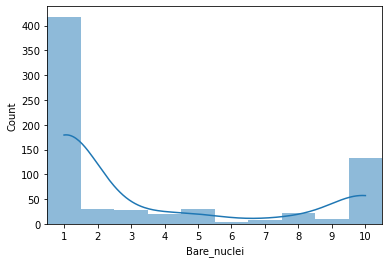

In [37]:
# Histogram + kernel density estimate of 'Bare_nuclei'
bins = np.arange(0, pd_data['Bare_nuclei'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Bare_nuclei'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

Most samples got a <i>Bare Nuclei</i> score of $1$. They are followed, in terms of quantity, by $10$ scored ones.

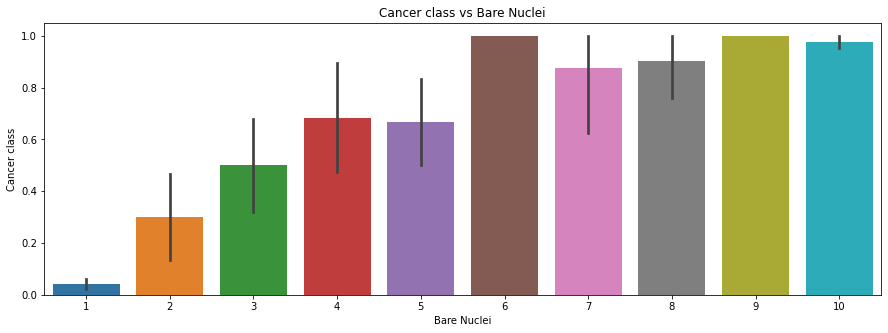

In [38]:
plt.figure(figsize=(15,5))
sns.barplot(x='Bare_nuclei',y='Class',data=pd_data)
plt.title('Cancer class vs Bare Nuclei')
plt.xlabel('Bare Nuclei')
plt.ylabel('Cancer class')
plt.show()

Samples scored $6$ or $9$ are classified as malignant only, but this is not so statistically relevant since they are only $13$.

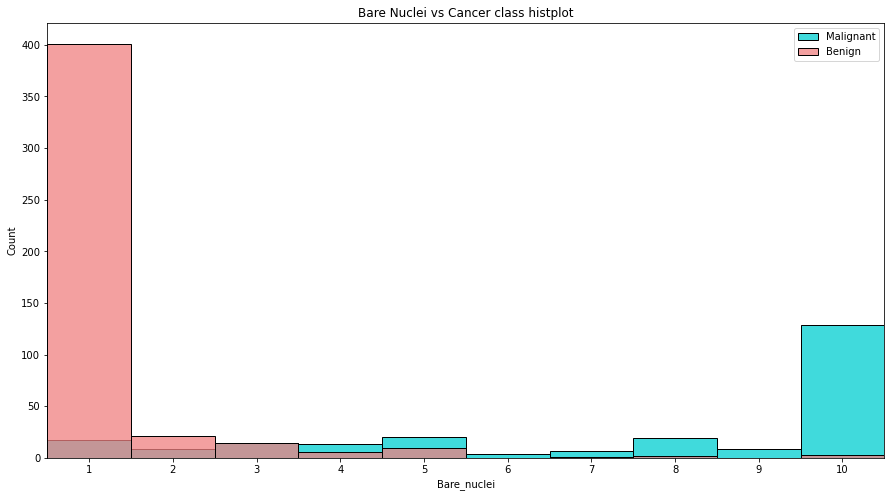

In [39]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Bare_nuclei[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins
)

sns.histplot(
    pd_data.Bare_nuclei[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

plt.legend(['Malignant', 'Benign'])
plt.title('Bare Nuclei vs Cancer class histplot')
plt.xlim(pd_data.Bare_nuclei.min() - 0.5, pd_data.Bare_nuclei.max() + 0.5)
plt.show()

As seen in the previous histogram, we have a great number of scores $= 1$, and those samples are mostly associated with benign cancer. Samples whose score is $= 10$ are mostly classified into malignant class.

<ul>
    <li><b><i>Bland Chromatin</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [40]:
pd_data['Bland_chromatin'].value_counts()

2     166
3     165
1     152
7      73
4      40
5      34
8      28
10     20
9      11
6      10
Name: Bland_chromatin, dtype: int64

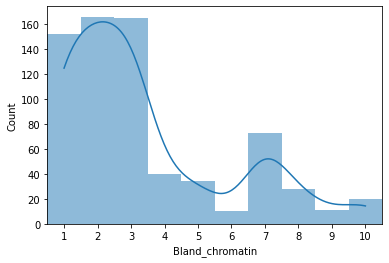

In [41]:
# Histogram + kernel density estimate of 'Bland_chromatin'
bins = np.arange(0, pd_data['Bland_chromatin'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Bland_chromatin'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

The majority of samples falls into {$1, 2, 3$} range.

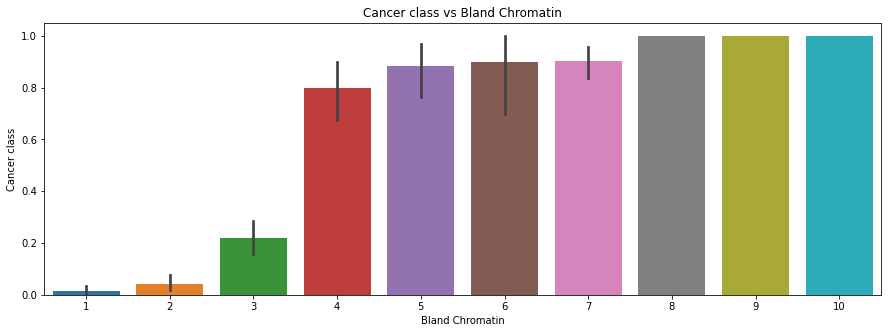

In [42]:
plt.figure(figsize=(15,5))
sns.barplot(x='Bland_chromatin',y='Class',data=pd_data)
plt.title('Cancer class vs Bland Chromatin')
plt.xlabel('Bland Chromatin')
plt.ylabel('Cancer class')
plt.show()

Samples whose scores is $\geq 4$ are mostly classified as malignant cancer, among them $\geq 8$ ones are classified as malignant cancer only.

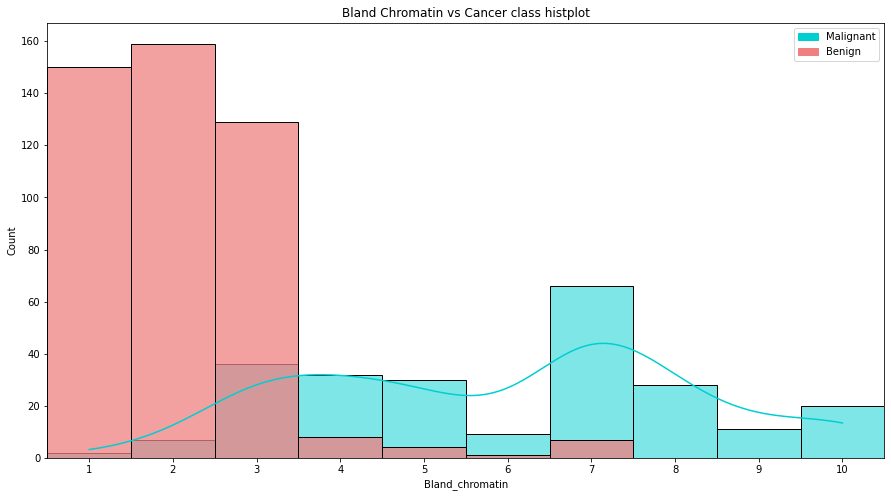

In [43]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Bland_chromatin[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins,
    kde=True
)

sns.histplot(
    pd_data.Bland_chromatin[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

m_patch = mpatches.Patch(color='darkturquoise', label='Malignant')
b_patch = mpatches.Patch(color='lightcoral', label='Benign')
plt.legend(handles=[m_patch, b_patch], loc='upper right')
plt.title('Bland Chromatin vs Cancer class histplot')
plt.xlim(pd_data.Bland_chromatin.min() - 0.5, pd_data.Bland_chromatin.max() + 0.5)
plt.show()

Benign cancer is strongly associated with $1$, $2$ and $3$ <i>Bland Chromatin</i>'s scores. Malignant class histplot vs <i>Bland Chromatin</i> results in higher bars (i.e., more samples) than previous obtained ones (especially samples scored $7$ has a highly chance to be classified as malignant, we also plotted the malignant KDE here in order to see its curve's height): according to literature and to recent studies, chromatin state and reshaping of it is highly correlated with cancer phenomena.

<ul>
    <li><b><i>Normal Nucleoli</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [44]:
pd_data['Normal_nucleoli'].value_counts()

1     443
10     61
3      44
2      36
8      24
6      22
5      19
4      18
9      16
7      16
Name: Normal_nucleoli, dtype: int64

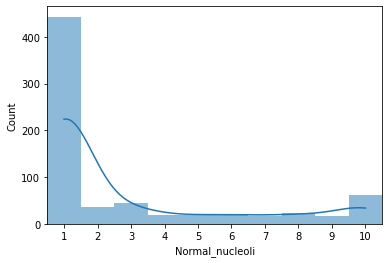

In [45]:
# Histogram + kernel density estimate of 'Normal_nucleoli'
bins = np.arange(0, pd_data['Normal_nucleoli'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Normal_nucleoli'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

Most samples got a <i>Normal Nucleoli</i> score of $1$.

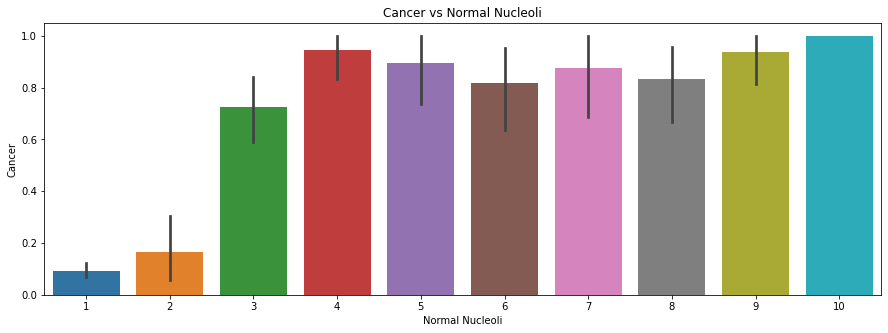

In [46]:
plt.figure(figsize=(15,5))
sns.barplot(x='Normal_nucleoli',y='Class',data=pd_data)
plt.title('Cancer vs Normal Nucleoli')
plt.xlabel('Normal Nucleoli')
plt.ylabel('Cancer')
plt.show()

Scores $\geq 3$ are associated with malignant cancer cells. Samples scored $10$ are classified as malignant cancer only.

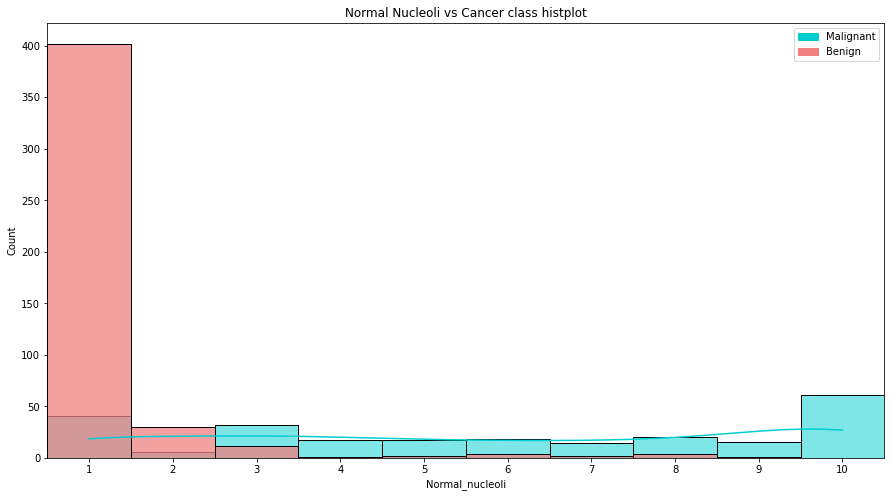

In [47]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Normal_nucleoli[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins,
    kde=True
)

sns.histplot(
    pd_data.Normal_nucleoli[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

m_patch = mpatches.Patch(color='darkturquoise', label='Malignant')
b_patch = mpatches.Patch(color='lightcoral', label='Benign')
plt.legend(handles=[m_patch, b_patch], loc='upper right')
plt.title('Normal Nucleoli vs Cancer class histplot')
plt.xlim(pd_data.Normal_nucleoli.min() - 0.5, pd_data.Normal_nucleoli.max() + 0.5)
plt.show()

The vast majority of cases has a unitary score and they are mainly associated with benign cancer. A low (almost constant) curved KDE is instead associated with this feature (it only raises a bit because of $10$ scored samples).

<ul>
    <li><b><i>Mitoses</i></b>: $n \in$ {$1, ..., 10$}.</li>
</ul>

In [48]:
pd_data['Mitoses'].value_counts()

1     579
2      35
3      33
10     14
4      12
7       9
8       8
5       6
6       3
Name: Mitoses, dtype: int64

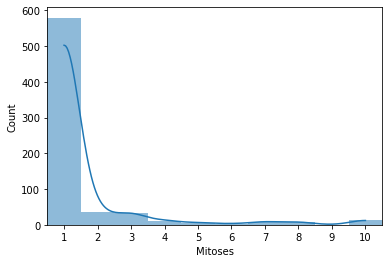

In [49]:
# Histogram + kernel density estimate of 'Mitoses'
bins = np.arange(0, pd_data['Mitoses'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
sns.histplot(pd_data['Mitoses'], bins=bins, kde=True, linewidth=0, ax=ax)
ax.set_xlim(0.5,10.5)
ax.set_xticks(range(1,10+1))
plt.show()

Most samples got a <i>Mitoses</i> score of $1$.

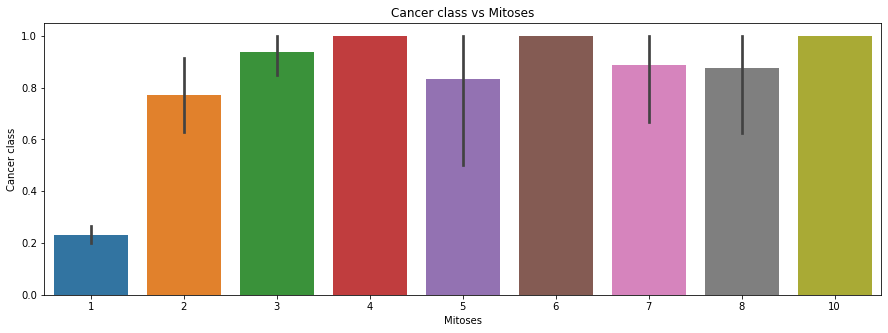

In [50]:
plt.figure(figsize=(15,5))
sns.barplot(x='Mitoses',y='Class',data=pd_data)
plt.title('Cancer class vs Mitoses')
plt.xlabel('Mitoses')
plt.ylabel('Cancer class')
plt.show()

Scores $\geq 2$ are indeed mainly classified into malignant class. A high number of samples is scored $1$ and around $20$% of them is neverthless associated with malignant class.

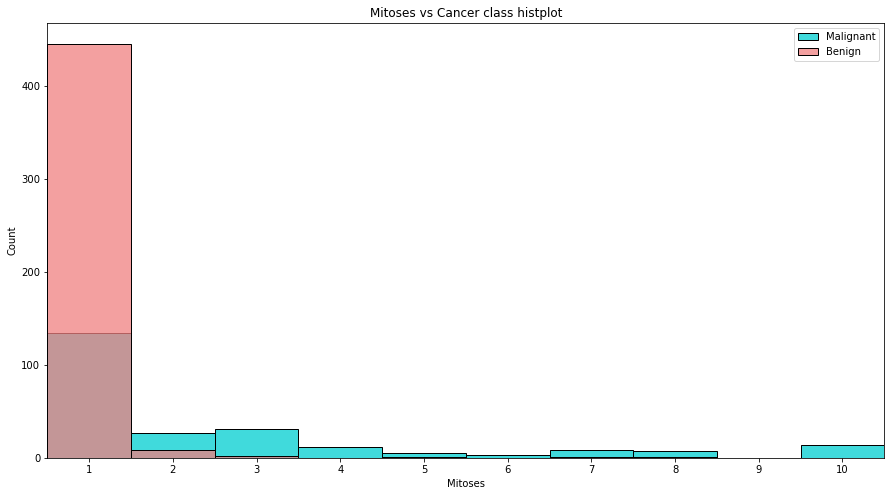

In [51]:
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.histplot(
    pd_data.Mitoses[pd_data['Class'] == 1], 
    color="darkturquoise", 
    bins=bins
)

sns.histplot(
    pd_data.Mitoses[pd_data['Class'] == 0], 
    color="lightcoral", 
    bins=bins
)

plt.legend(['Malignant', 'Benign'])
plt.title('Mitoses vs Cancer class histplot')
plt.xlim(pd_data.Mitoses.min() - 0.5, pd_data.Mitoses.max() + 0.5)
plt.show()

Benign class samples are mainly scored $1$, but we notice also a peak of malignant ones within this score.

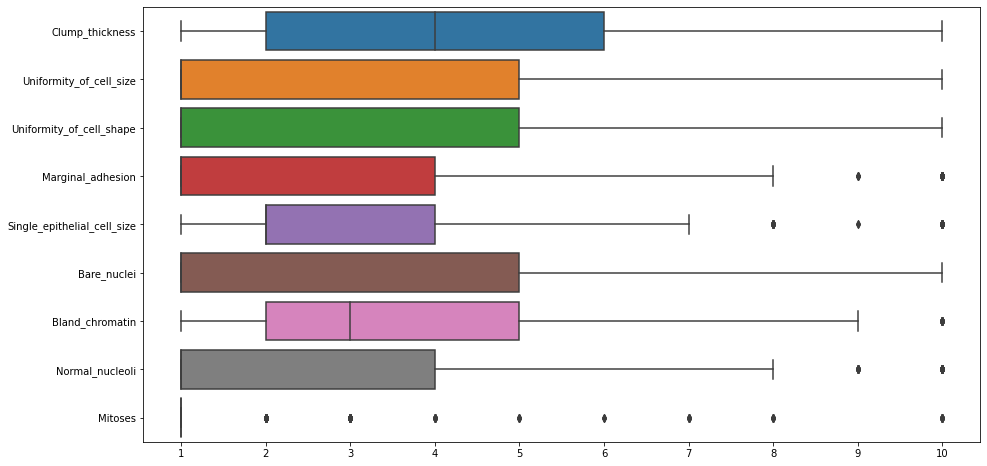

In [52]:
# Boxplot summary
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.boxplot(data=pd_data.drop(columns='Class'),orient="h");

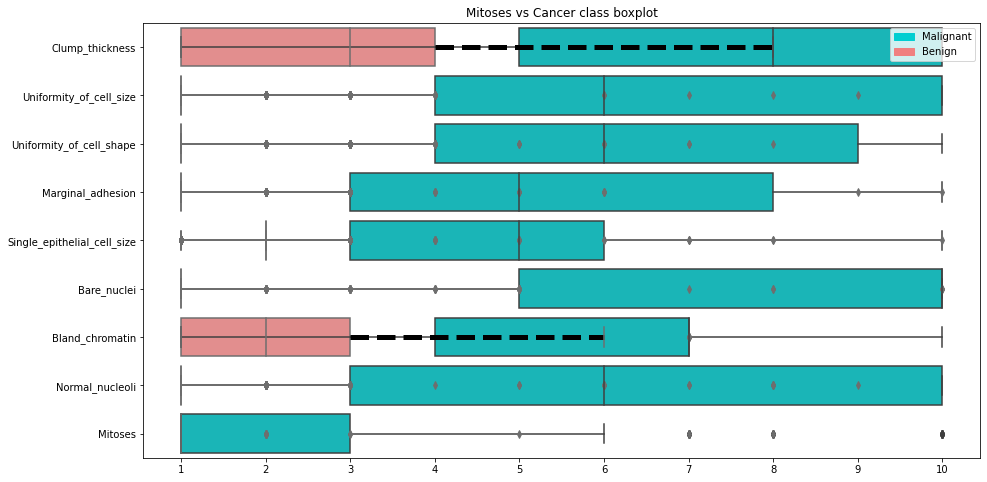

In [53]:
# Boxplot summary per class
_, ax = plt.subplots(figsize=(15,8))
ax.set_xticks(range(1,10+1))
sns.boxplot(
    data=pd_data[pd_data['Class'] == 1].drop(columns='Class'), 
    color="darkturquoise", 
    orient="h"
)

sns.boxplot(
    data=pd_data[pd_data['Class'] == 0].drop(columns='Class'), 
    color="lightcoral", 
    orient="h",
    whiskerprops = dict(linestyle='--',linewidth=5.0, color='black')
)

m_patch = mpatches.Patch(color='darkturquoise', label='Malignant')
b_patch = mpatches.Patch(color='lightcoral', label='Benign')
plt.legend(handles=[m_patch, b_patch], loc='upper right')
plt.title('Mitoses vs Cancer class boxplot')
plt.show()

As we saw, samples classified as benign tend to have a distribution (except <i>Clump Thickness</i> and <i>Bland Chromatin</i>, but they always tend to be close to low values, i.e., third quartile respectively $= 4$ and $3$) very close to $= 1$.<br>We can also notice samples classified as malignant tend to have a wider distribution characterized by higher values (except for <i>Mitoses</i>, as we saw before).

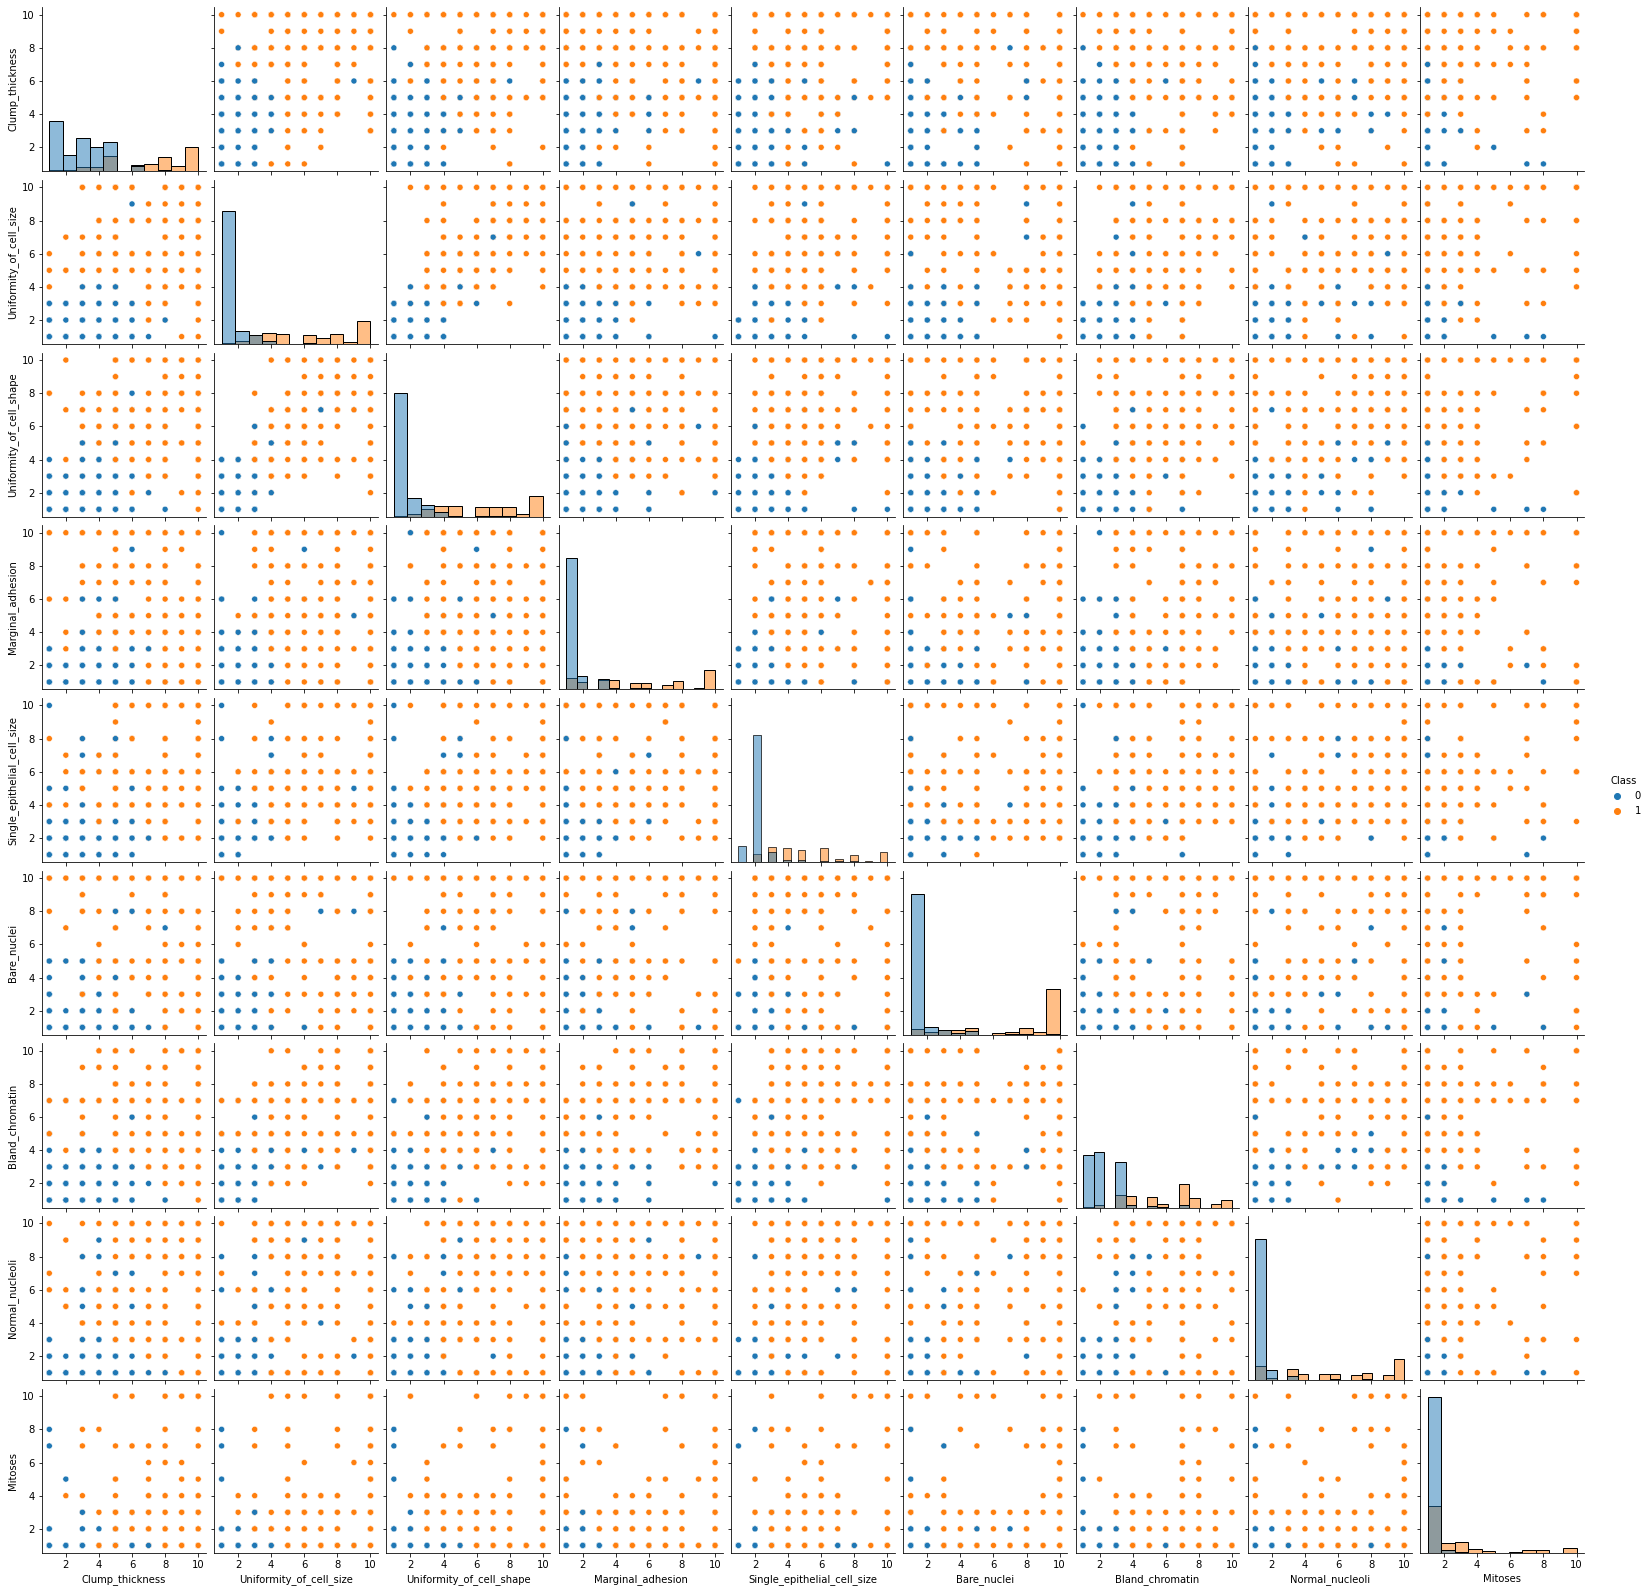

In [54]:
# Pairplot of all variables
_ = sns.pairplot(pd_data, hue='Class', height=2.5, diag_kind='hist')

The diagonal summarizes what we have seen in details before considering features vs <i>Class</i> histplots.

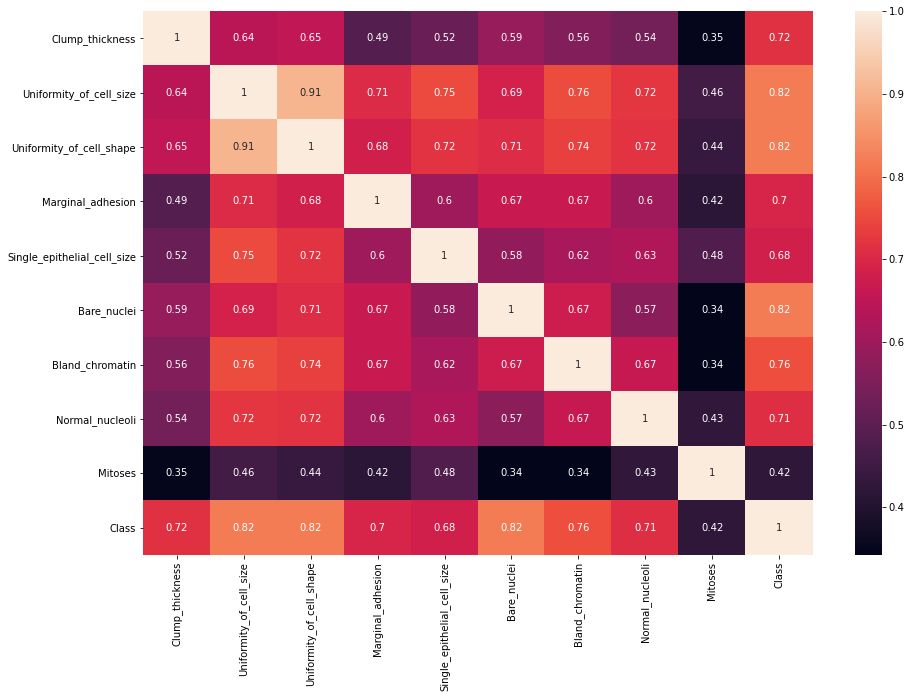

In [55]:
# Correlation matrix
_ = plt.figure(figsize=(15,10))
corrMatrix = pd_data.corr()
_ = sns.heatmap(corrMatrix, annot=True)
plt.show()

As we expected, <i>Uniformity of Cell Size</i> and <i>Shape</i> are highly correlated.

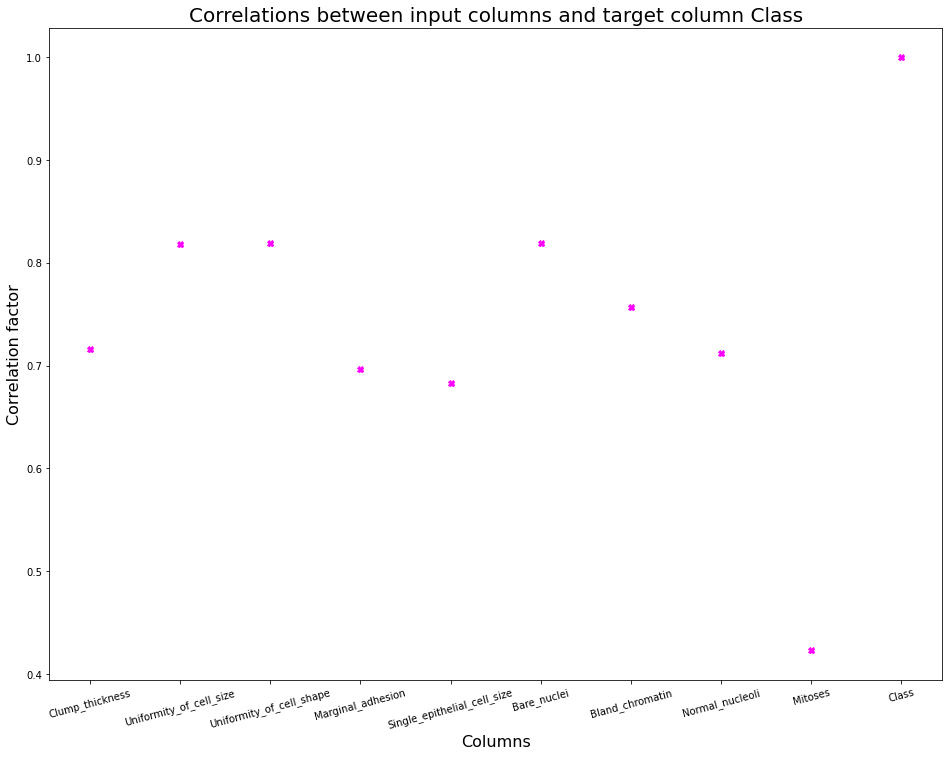

In [56]:
autcorr = pd_data.corr()["Class"]
plt.figure(figsize = (16, 12))
plt.title("Correlations between input columns and target column Class", fontsize = 20)
plt.xlabel("Columns", fontsize = 16)
plt.xticks(rotation = 15) # X axis' rotation = 15°
plt.ylabel("Correlation factor", fontsize = 16)
plt.plot(autcorr, color = "magenta", linestyle = "", marker = "X")
plt.show()

Cancer class (<i>Class</i>, malignant or benign) strongly correlates with <i>Uniformity of Cell Size</i>, <i>Uniformity of Cell Shape</i> and <i>Bare Nuclei</i> features. As one could already image from previous analysis, <i>Mitoses</i> is lowly correlated with our target class.

We will use this dataframe for building our ML model for classification.

In [57]:
pd_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Clump_thickness,699.0,4.417740,2.815741,1.0,2.0,4.0,6.0,10.0
Uniformity_of_cell_size,699.0,3.134478,3.051459,1.0,1.0,1.0,5.0,10.0
Uniformity_of_cell_shape,699.0,3.207439,2.971913,1.0,1.0,1.0,5.0,10.0
Marginal_adhesion,699.0,2.806867,2.855379,1.0,1.0,1.0,4.0,10.0
Single_epithelial_cell_size,699.0,3.216023,2.214300,1.0,2.0,2.0,4.0,10.0
Bare_nuclei,699.0,3.486409,3.621929,1.0,1.0,1.0,5.0,10.0
Bland_chromatin,699.0,3.437768,2.438364,1.0,2.0,3.0,5.0,10.0
Normal_nucleoli,699.0,2.866953,3.053634,1.0,1.0,1.0,4.0,10.0
Mitoses,699.0,1.589413,1.715078,1.0,1.0,1.0,1.0,10.0
Class,699.0,0.344778,0.475636,0.0,0.0,0.0,1.0,1.0


# Multiple Logistic Regression
Multiple (i.e., multivariable) Logistic Regression is a classification method that uses the logistic function to predict the probability of a data point to belong to a specific class.

Train accuracy: 0.9713740458015268
Train recall: 0.9619565217391305


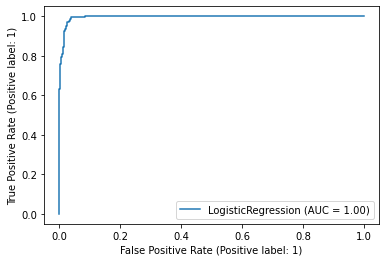

In [58]:
split_seed = 42
split_test_size = 0.25 # 75% of data --> train set; 25% of data --> test set

# Train a logistic regressor that uses all features
X_full = pd_data.drop(['Class'], axis=1)
y = pd_data['Class']

X_full_train, X_full_test, y_train, y_test = train_test_split(X_full, y,
                                                    test_size=split_test_size,
                                                    random_state=split_seed)

model = LogisticRegression(solver='newton-cg', penalty='none') 
model.fit(X_full_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_full_train)))
print("Train recall:", recall_score(y_train, model.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(model, X_full_train, y_train)

Test accuracy: 0.9542857142857143
Test recall: 0.8947368421052632


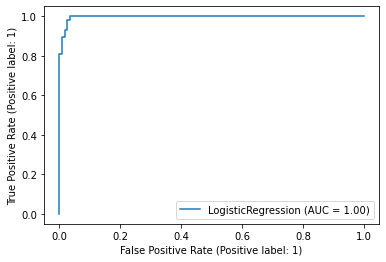

In [59]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_full_test)))
print("Test recall:", recall_score(y_test, model.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(model, X_full_test, y_test)

Sensitivity  0.8947368421052632
Specificity  0.9830508474576272
Precision  0.9622641509433962
F1-score 0.9272727272727272 

              precision    recall  f1-score   support

      Benign       0.95      0.98      0.97       118
   Malignant       0.96      0.89      0.93        57

    accuracy                           0.95       175
   macro avg       0.96      0.94      0.95       175
weighted avg       0.95      0.95      0.95       175



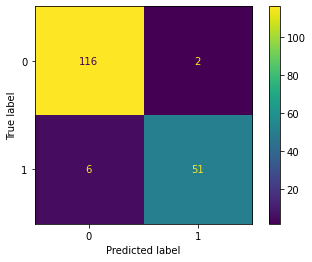

In [60]:
def sensitivity(cm):
    TP = cm[1,1]
    T = cm[1,:].sum()
    return TP / T

def specificity(cm):
    TN = cm[0,0]
    N = cm[0,:].sum()
    return TN / N

def precision(cm):
    TP = cm[1,1]
    TPFP = cm[:,1].sum()
    return TP / TPFP

def f1(cm):
    p = precision(cm)
    r = sensitivity(cm)
    return (2 * p * r) / (p + r)

cm = confusion_matrix(y_test, model.predict(X_full_test))
# Plot test confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_full_test), target_names=['Benign', 'Malignant']))

The model has quite good accuracy and recall scores which doesn't suggest an overfitting of the model to the data. 

The best model is the one having a ROC curve that hugs the top left corner, that is, having a very high true positive rate and a very lor false positive rate. The diagonal represents a random guess model that (in the case of two classes, which is ours) output positive with $50$% probability.

In our scenario, Logistic Regression involving all features at disposal performs excellent (test AUC $= 1$ and F$1$-score $= 0.93$).

Depending on the application, we may want to increase the sensitivity for a specific class (e.g., in a clinical test we may prefer to say that the patient is positive even if it is not, rather than missing a positive patient).

By default (and we will follow that parameter), a $50$% threshold is used to discriminate between two classes. However, if we want to increase the sensitivity of a class we can lower its threshold, therefore more likely predicting that class over the alternative.

In [61]:
def predict_th(model, X, th):
    prob = model.predict_proba(X)
    y = prob[:,1] >= th
    return y

cm = confusion_matrix(y_test, predict_th(model, X_full_test, th=0.3))

print("Sensitivity ", sensitivity(cm))

Sensitivity  0.9298245614035088


Back to us, a Logistic Regression model that takes into account all features results in an optimal test AUC (Area Under the Curve $= 1$; i.e., we built an almost perfect model in terms of test accuracy and recall).

However, let's compute the statistical significance of features to check if a feature is actually needed through a z test.

In [62]:
def z_test(X, y, model, names, alpha=None):
    n_samples, n_features = X.shape
    betas = np.concatenate([model.intercept_, model.coef_.reshape(-1)])
    
    # Compute the prediction
    pred = model.predict_proba(X) # [N, 2]
    y = y.reshape(-1)    
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    n_samples, n_features = X.shape
    
    V = np.diagflat(np.product(pred, axis=1))
    covLogit = np.linalg.inv(np.dot(np.dot(X.T, V), X))
    se_b = np.sqrt(np.diag(covLogit)) 
    
    z_stat_b = (betas-0)/se_b

    # Compute the p-value (two-sided test)
    p_values = np.array([2 * norm.sf(np.abs(z_stat)) for z_stat in z_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = np.round(se_b, decimals=4)
    df["Z-stat"] = np.round(z_stat_b, decimals=1)
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    return df

X_full_feat = X_full_train.columns
z_test(X_full_train.to_numpy(), y_train.to_numpy(), model, ["Intercept", *X_full_feat], alpha=0.05)

,Name,Coefficients,Standard Errors,Z-stat,p-value,reject H0
0,Intercept,-9.622506,1.2060,-8.0,1.473703e-15,True
1,Clump_thickness,0.524012,0.1548,3.4,7.140942e-04,True
2,Uniformity_of_cell_size,-0.048409,0.2394,-0.2,8.397485e-01,False
3,Uniformity_of_cell_shape,0.456980,0.2706,1.7,9.128622e-02,False
4,Marginal_adhesion,0.200238,0.1290,1.6,1.207291e-01,False
5,Single_epithelial_cell_size,0.139204,0.1625,0.9,3.916081e-01,False
6,Bare_nuclei,0.435326,0.0987,4.4,1.039449e-05,True
7,Bland_chromatin,0.404408,0.1749,2.3,2.079398e-02,True
8,Normal_nucleoli,0.003878,0.1243,0.0,9.751050e-01,False
9,Mitoses,0.375752,0.3062,1.2,2.198072e-01,False


According to a $0.05$ $\alpha$ threshold, <i>Clump_thickness</i>, <i>Bare_nuclei</i> and <i>Bland_chromatin</i> result statistically significant.

In [63]:
X_feat = ['Clump_thickness', 'Bare_nuclei', 'Bland_chromatin']
        
X = pd_data[X_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=split_seed)

model = LogisticRegression(solver='newton-cg', penalty='none') 
model.fit(X_train, y_train)

z_test(X_train.to_numpy(), y_train.to_numpy(), model, ["Intercept", *X_feat], alpha=0.05)

,Name,Coefficients,Standard Errors,Z-stat,p-value,reject H0
0,Intercept,-9.208092,0.9918,-9.3,1.628432e-20,True
1,Clump_thickness,0.748427,0.1260,5.9,2.819496e-09,True
2,Bare_nuclei,0.579463,0.0934,6.2,5.503203e-10,True
3,Bland_chromatin,0.717111,0.1345,5.3,9.631307e-08,True


Train accuracy: 0.9618320610687023
Train recall: 0.9456521739130435


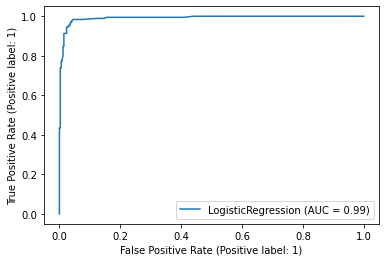

In [64]:
print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Train recall:", recall_score(y_train, model.predict(X_train)))
_ = RocCurveDisplay.from_estimator(model, X_train, y_train)

Test accuracy: 0.96
Test recall: 0.9122807017543859


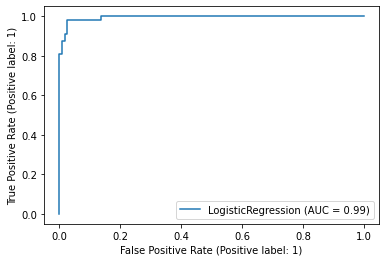

In [65]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_test)))
print("Test recall:", recall_score(y_test, model.predict(X_test)))
_ = RocCurveDisplay.from_estimator(model, X_test, y_test)

Sensitivity  0.9122807017543859
Specificity  0.9830508474576272
Precision  0.9629629629629629
F1-score 0.9369369369369369 

              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97       118
   Malignant       0.96      0.91      0.94        57

    accuracy                           0.96       175
   macro avg       0.96      0.95      0.95       175
weighted avg       0.96      0.96      0.96       175



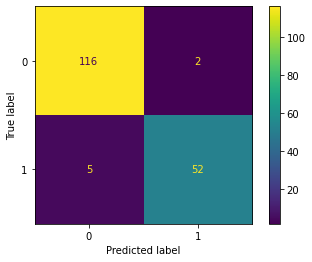

In [66]:
cm = confusion_matrix(y_test, model.predict(X_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_test), target_names=['Benign', 'Malignant']))

Selecting only statistically significant features according to z test, we improved a bit test recall, sensitivity and therefore F$1$-score (from $0.93$ to $0.94$).

## Forward Feature Selection

Forward Feature Selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model. Being $p$ the number of features, its computational complexity is $O(p^2)$.

We will use the cross validation accuracy (or classification error) to decide which is the best number of features to select, while the train accuracy/error for selecting the candidates.

In [67]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def forward_selection(classifier, Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A counter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = classifier
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n Best configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how the 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M1) with 1 features: ['Uniformity_of_cell_shape']
M1 subset score (3.): 0.9294629898403484
............
Best model (M2) with 2 features: ['Uniformity_of_cell_shape', 'Bare_nuclei']
M2 subset score (3.): 0.9542452830188679
............
Best model (M3) with 3 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness']
M3 subset score (3.): 0.9675979680696661
............
Best model (M4) with 4 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Normal_nucleoli']
M4 subset score (3.): 0.9675979680696661
............
Best model (M5) with 5 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Normal_nucleoli', 'Bland_chromatin']
M5 subset score (3.): 0.9657111756168361
............
Best model (M6) with 6 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Normal_nucleoli', 'Bland_chromatin', 'Single_epithelial_cell_size']
M6 subset score (3.): 0.9695210449927429
............
Best model (M7

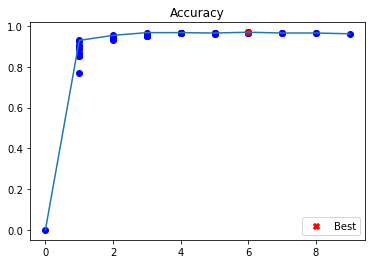

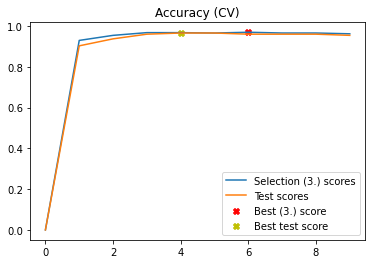

In [68]:
cv = 10

forward_selection(LogisticRegression(solver="newton-cg", penalty='none'),
                  X_full_train, y_train, X_full_test, y_test,
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv)

<i>Uniformity_of_cell_shape</i>, <i>Bare_nuclei</i>, <i>Clump_thickness</i>, <i>Normal_nucleoli</i>, <i>Bland_chromatin</i> and <i>Single_epithelial_cell_size</i> give us the best subset score in terms of accuracy, according to Forward Feature Selection. We recall this is a greedy algorithm (which does not reconsider previous choices), so we have no guarantee that the best possible subset is chosen. Adding other features reduces the score of the subset.

<i>Clump_thickness</i>, <i>Bare_nuclei</i>, <i>Bland_chromatin</i> (features we saw are statistically significant according to z test with an $\alpha$ threshold of $0.05$) are present here too, although the two methods rely on very different assumptions. We generally expect features with strong statistical tests rejection (very low p-value) to be selected first in Forward Feature Selection compared to other ones, as it is the case of <i>Bare_nuclei</i> and <i>Clump_thickness</i>.

Train accuracy: 0.9694656488549618
Train recall: 0.9565217391304348


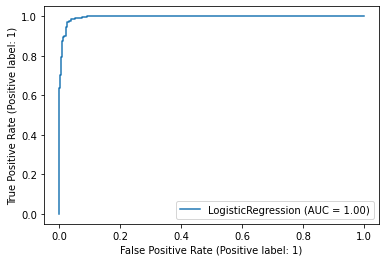

In [69]:
X_feat = ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness',
          'Normal_nucleoli', 'Bland_chromatin', 'Single_epithelial_cell_size']
        
X = pd_data[X_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=split_seed)

model = LogisticRegression(solver='newton-cg', penalty='none') 
model.fit(X_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Train recall:", recall_score(y_train, model.predict(X_train)))
_ = RocCurveDisplay.from_estimator(model, X_train, y_train)

Test accuracy: 0.96
Test recall: 0.9122807017543859


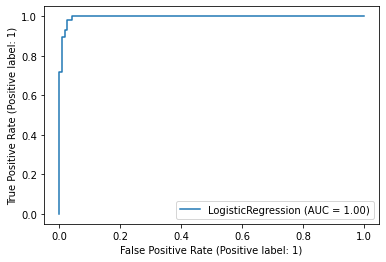

In [70]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_test)))
print("Test recall:", recall_score(y_test, model.predict(X_test)))
_ = RocCurveDisplay.from_estimator(model, X_test, y_test)

Sensitivity  0.9122807017543859
Specificity  0.9830508474576272
Precision  0.9629629629629629
F1-score 0.9369369369369369 

              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97       118
   Malignant       0.96      0.91      0.94        57

    accuracy                           0.96       175
   macro avg       0.96      0.95      0.95       175
weighted avg       0.96      0.96      0.96       175



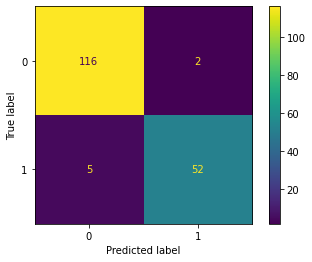

In [71]:
cm = confusion_matrix(y_test, model.predict(X_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_test), target_names=['Benign', 'Malignant']))

Test AUC remains the same ($1$); test sensitivity, specificity, precision and F$1$-score are identical to the previous model obtained involving the z test (which has the advantage of selecting a lower number of features).

## Feature selection with Lasso

The shrinkage effect of <b>L$1$-norm</b> can be used for feature selection. By gradually increasing the $\lambda$ parameter (i.e., increasing the sparsity of the model), the parameters that go to zero first will likely be the least important ones.

To ensure parameters are within the same ranges for different lambda values, we first normalize the data to have $0$ mean and unitary standard deviation.

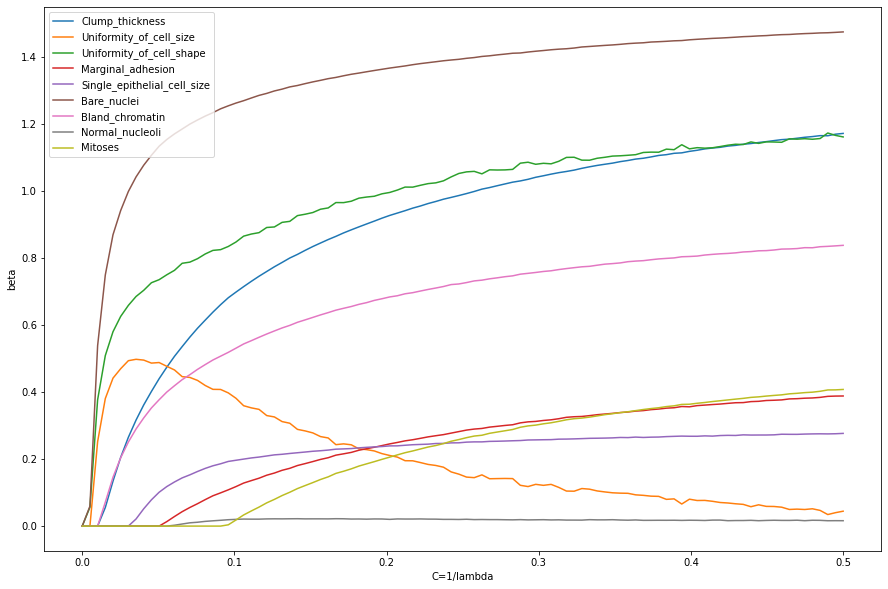

In [72]:
C_vals = np.linspace(1e-4, 0.5, 100) # The 'C' argument controls the lambda parameter
                                     # in the loss (defined as the opposite of lambda):
                                     # smaller values specify stronger regularization.
betas = []

X_std = preprocessing.scale(X_full_train)

for C in C_vals:
    model = LogisticRegression(solver='liblinear', penalty='l1', C=C) # Note: L1-norm regularization
                                                                      # is not available for all the solvers.
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    #beta = (beta - beta.min()) / beta.ptp()
    betas.append(beta)
betas = np.stack(betas, axis=1)  # [Nfeat, NCvals]

_ = plt.figure(figsize=(15,10))
for beta, name in zip(betas, X_full_train):
    _ = plt.plot(C_vals, beta, label=name)
_ = plt.legend()
_ = plt.xlabel("C=1/lambda")
_ = plt.ylabel("beta")

If we read the graph from left to right, that is, from very high regularization (left) to low regularization (right), we see a behaviour similar to the one observed with Forward Feature Selection. 

- The last feature to disappear is <i>Bare_nuclei</i>, which is also the second one added by Forward Feature Selection algorithm and the one with the lower p-value. So we can think of that feature as the most important one for prediction, with <i>Uniformity_of_cell_shape</i> and <i>Uniformity_of_cell_size</i> following. We already knew these features are also highly correlated with the <i>Class</i> outcome.
- The first one to go to zero, as we could already expect from previous analysis, is <i>Mitoses</i> which was also one of the last being added to Forward Feature Selection, the one having the lowest correlation with the outcome and a large p-value in statistical z test.

Now we select $\lambda$ according to cross-validation. 

In [73]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('classifier',LogisticRegression(solver='liblinear', penalty='l1'))])

params = {'classifier__C': C_vals}
cv = GridSearchCV(model, params, refit=True, cv=10, verbose=False, scoring=make_scorer(accuracy_score))
# Same results with recall_score instead of accuracy
cv.fit(X_full_train, y_train)

best_C = cv.best_params_["classifier__C"]
print("The best parameter for lasso is: C =", best_C)
print("Which corresponds to: lambda = 1/C =", 1 / best_C)

The best parameter for lasso is: C = 0.030396969696969697
Which corresponds to: lambda = 1/C = 32.8980161499352


Train accuracy: 0.9694656488549618
Train recall: 0.9565217391304348


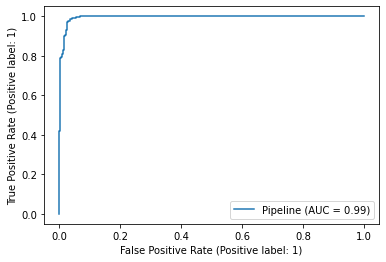

In [74]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
                 ('classifier',LogisticRegression(solver='liblinear', penalty='l1', C=best_C))])
model.fit(X_full_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_full_train)))
print("Train recall:", recall_score(y_train, model.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(model, X_full_train, y_train)

Test accuracy: 0.9485714285714286
Test recall: 0.9122807017543859


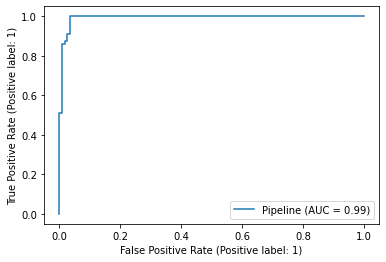

In [75]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_full_test)))
print("Test recall:", recall_score(y_test, model.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(model, X_full_test, y_test)

Sensitivity  0.9122807017543859
Specificity  0.9661016949152542
Precision  0.9285714285714286
F1-score 0.9203539823008849 

              precision    recall  f1-score   support

      Benign       0.96      0.97      0.96       118
   Malignant       0.93      0.91      0.92        57

    accuracy                           0.95       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.95      0.95      0.95       175



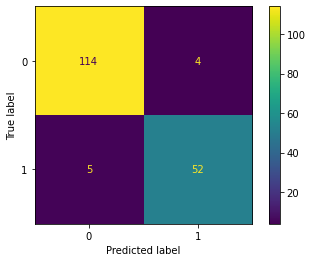

In [76]:
cm = confusion_matrix(y_test, model.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_full_test), target_names=['Benign', 'Malignant']))

Comparing it to full featured model, we improved a bit test recall score and we lost a bit of specificity in favour of sensitivity.

## Ridge Regression
Ridge regression is a shrinkage method that fit a model containing all the predictors and shrinks the coefficients estimates toward zero, reducing their variance. It uses as shrinkage penalty the <b>L$2$-norm</b> of the vector of coefficients.

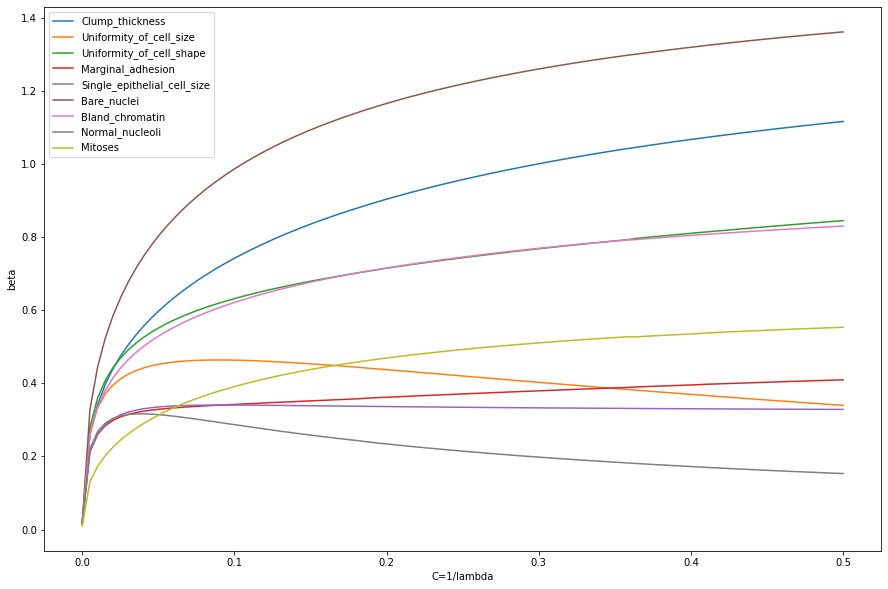

In [77]:
betas = []

for C in C_vals:
    model = LogisticRegression(solver='liblinear', penalty='l2', C=C) # Note: L2-norm regularization
                                                                      # is not available for all the solvers.
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    #beta = (beta - beta.min()) / beta.ptp()
    betas.append(beta)
betas = np.stack(betas, axis=1)  # [Nfeat, NCvals]

_ = plt.figure(figsize=(15,10))
for beta, name in zip(betas, X_full_train):
    _ = plt.plot(C_vals, beta, label=name)
_ = plt.legend()
_ = plt.xlabel("C=1/lambda")
_ = plt.ylabel("beta")

We obtained a similar graph with respect to Lasso, from which we can reach similar considerations: <i>Bare_nuclei</i>, <i>Clump_thickness</i>, <i>Uniformity_of_cell_shape</i> and <i>Bland_chromatin</i> are the features with highest betas for the same $C$s, therefore the most meaningful ones.

Now we select $\lambda$ according to cross-validation using accuracy as metric. 

In [78]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
                 ('classifier',LogisticRegression(solver='liblinear', penalty='l2'))])

params = {'classifier__C': C_vals}
cv = GridSearchCV(model, params, refit=True, cv=10, verbose=False, scoring=make_scorer(accuracy_score))
cv.fit(X_full_train, y_train)

best_C = cv.best_params_["classifier__C"]
print("The best parameter for ridge regression is: C =", best_C)
print("Which corresponds to: lambda = 1/C =", 1 / best_C)

The best parameter for ridge regression is: C = 0.00514949494949495
Which corresponds to: lambda = 1/C = 194.1938014907807


Train accuracy: 0.9713740458015268
Train recall: 0.9728260869565217


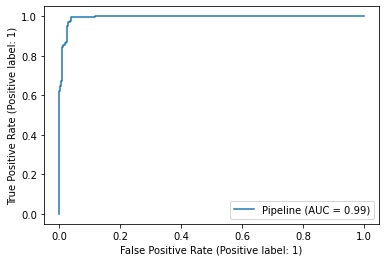

In [79]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
                 ('classifier',LogisticRegression(solver='liblinear', penalty='l2', C=best_C))])
model.fit(X_full_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_full_train)))
print("Train recall:", recall_score(y_train, model.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(model, X_full_train, y_train)

Test accuracy: 0.9657142857142857
Test recall: 0.9473684210526315


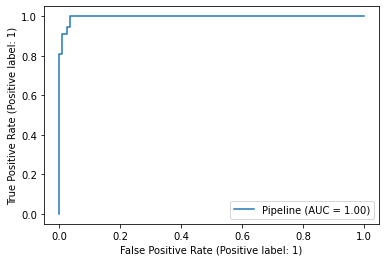

In [80]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_full_test)))
print("Test recall:", recall_score(y_test, model.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(model, X_full_test, y_test)

Sensitivity  0.9473684210526315
Specificity  0.9745762711864406
Precision  0.9473684210526315
F1-score 0.9473684210526315 

              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       118
   Malignant       0.95      0.95      0.95        57

    accuracy                           0.97       175
   macro avg       0.96      0.96      0.96       175
weighted avg       0.97      0.97      0.97       175



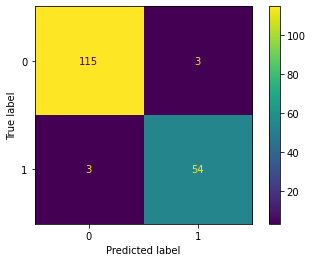

In [81]:
cm = confusion_matrix(y_test, model.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_full_test), target_names=['Benign', 'Malignant']))

We obtained a very good model, with balanced test sensitivity and specificity resulting in an F$1$-score reaching a very high value of $0.95$. Let's now consider recall metric.

In [82]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
               ('classifier',LogisticRegression(solver='liblinear', penalty='l2'))])

params = {'classifier__C': C_vals}
cv = GridSearchCV(model, params, refit=True, cv=10, verbose=False, scoring=make_scorer(recall_score))
cv.fit(X_full_train, y_train)

best_C = cv.best_params_["classifier__C"]
print("The best parameter for ridge regression is: C =", best_C)
print("Which corresponds to: lambda =", 1 / best_C)

The best parameter for ridge regression is: C = 0.0001
Which corresponds to: lambda = 10000.0


Train accuracy: 0.9694656488549618
Train recall: 0.9728260869565217


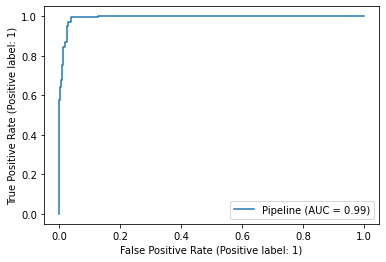

In [83]:
model = Pipeline([('scaler',preprocessing.StandardScaler()), 
                 ('classifier',LogisticRegression(solver='liblinear', penalty='l2', C=best_C))])
model.fit(X_full_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_full_train)))
print("Train recall:", recall_score(y_train, model.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(model, X_full_train, y_train)

Test accuracy: 0.96
Test recall: 0.9473684210526315


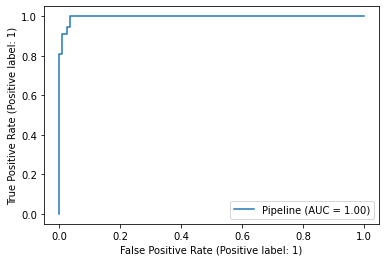

In [84]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_full_test)))
print("Test recall:", recall_score(y_test, model.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(model, X_full_test, y_test)

Sensitivity  0.9473684210526315
Specificity  0.9661016949152542
Precision  0.9310344827586207
F1-score 0.9391304347826087 

              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       118
   Malignant       0.93      0.95      0.94        57

    accuracy                           0.96       175
   macro avg       0.95      0.96      0.95       175
weighted avg       0.96      0.96      0.96       175



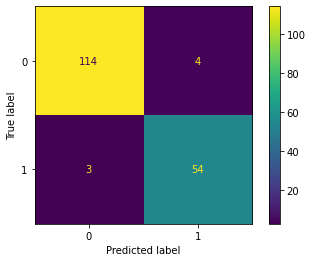

In [85]:
cm = confusion_matrix(y_test, model.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_full_test), target_names=['Benign', 'Malignant']))

Considering recall as cross-validation metric we loose a bit of precision on test set.<br>
However, Ridge Regression performs excellent on this dataset, reaching an F$1$-score of $0.95$ considering accuracy as cross-validation metric to find the best $\lambda$.

## Logistic Regression with polynomial features
<b>Best degree</b>: as usual, if we are interested in finding the optimal hyper-parameter for an agorithm we can use cross-validation and `GridSearchCV`. We'll take into account, as before, accuracy and recall metrics.

Having reached very high scores using a Logistic Regression without polynomial features, we expect the best degree to be $1$ (i.e., degrees $\geq 2$ cause an <b>overfitting</b> issue).

  (best 1) CV accuracy: 0.961901306240929
  (best 1) Test accuracy: 0.9542857142857143


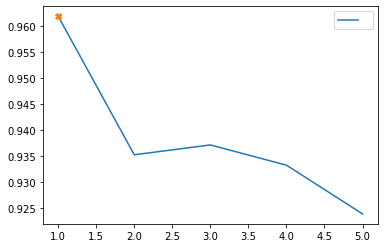

In [86]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lr', LogisticRegression(solver='lbfgs', penalty='none'))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy_score))
cv.fit(X_full_train, y_train)

def show_results_acc(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    # Plot the CV (mean) scores for all possible parameters
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    # Find the best
    best_idx = np.argmax(results['mean_test_score'])
    # Plot it as a cross
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx], marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV accuracy:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test accuracy:", accuracy_score(y_test, cv.best_estimator_.predict(X_test)))
    
show_results_acc(cv, X_full_test, 'param_poly__degree')

Considering recall as CV metric, we should expect the same result (best degree $= 1$).

  (best 1) CV recall: 0.9406432748538011
  (best 1) Test recall: 0.8947368421052632


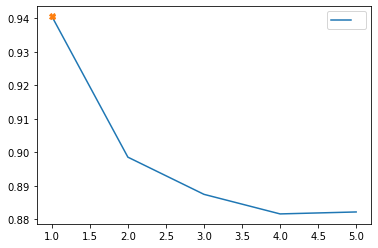

In [87]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lr', LogisticRegression(solver='lbfgs', penalty='none'))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(recall_score))
cv.fit(X_full_train, y_train)

def show_results_rec(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    # Plot the CV (mean) scores for all possible parameters
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    # Find the best
    best_idx = np.argmax(results['mean_test_score'])
    # Plot it as a cross
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx], marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV recall:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test recall:", recall_score(y_test, cv.best_estimator_.predict(X_test)))
    
show_results_rec(cv, X_full_test, 'param_poly__degree')

As hypothesized, considering accuracy and recall metrics, we obtain that degree $=1$ is the best. Degrees $\geq 2$ end up in overfitting.

# Linear Discriminant Analysis
Linear discriminant analysis is a classifier that uses the Bayes theorem to compute the a posteriori probability, which is then used to decide to which class each point is more likely to come from. LDA assumes that the data comes from a gaussian, with all the classes having the same variance.

Train accuracy: 0.9599236641221374
Train recall: 0.9239130434782609


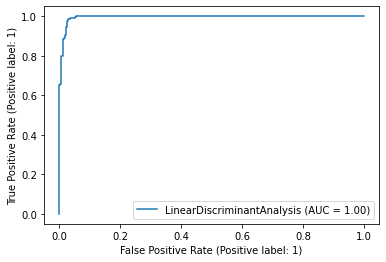

In [88]:
model = LDA(store_covariance=True)
model.fit(X_full_train, y_train) 

print("Train accuracy:", accuracy_score(y_train, model.predict(X_full_train)))
print("Train recall:", recall_score(y_train, model.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(model, X_full_train, y_train)

Test accuracy: 0.9542857142857143
Test recall: 0.8947368421052632


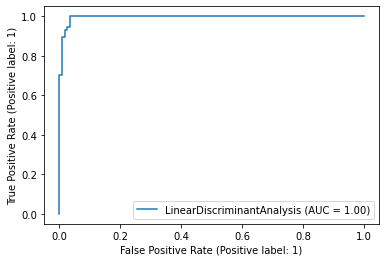

In [89]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_full_test)))
print("Test recall:", recall_score(y_test, model.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(model, X_full_test, y_test)

Sensitivity  0.8947368421052632
Specificity  0.9830508474576272
Precision  0.9622641509433962
F1-score 0.9272727272727272 

              precision    recall  f1-score   support

      Benign       0.95      0.98      0.97       118
   Malignant       0.96      0.89      0.93        57

    accuracy                           0.95       175
   macro avg       0.96      0.94      0.95       175
weighted avg       0.95      0.95      0.95       175



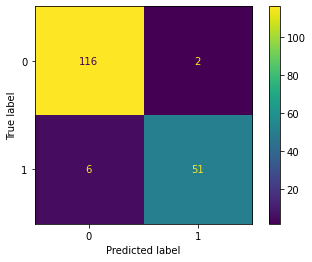

In [90]:
cm = confusion_matrix(y_test, model.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_full_test), target_names=['Benign', 'Malignant']))

LDA involving all fatures at disposal performs very similar to logistic regression. Let's see what happens by performing Forward Feature Selection (regularization methods such as Lasso and Ridge Regression cannot be used for LDA).

............
Best model (M1) with 1 features: ['Uniformity_of_cell_shape']
M1 subset score (3.): 0.9026850507982582
............
Best model (M2) with 2 features: ['Uniformity_of_cell_shape', 'Bare_nuclei']
M2 subset score (3.): 0.9504354136429607
............
Best model (M3) with 3 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness']
M3 subset score (3.): 0.9580914368650217
............
Best model (M4) with 4 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Mitoses']
M4 subset score (3.): 0.9619375907111756
............
Best model (M5) with 5 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Mitoses', 'Uniformity_of_cell_size']
M5 subset score (3.): 0.9619375907111756
............
Best model (M6) with 6 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Mitoses', 'Uniformity_of_cell_size', 'Single_epithelial_cell_size']
M6 subset score (3.): 0.961901306240929
............
Best model (M7) with 7 

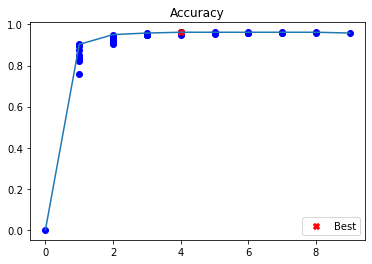

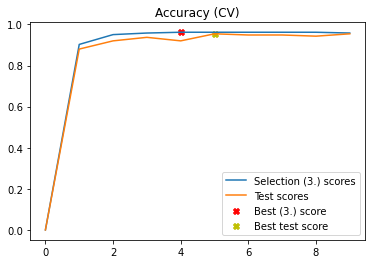

In [91]:
cv = 10

forward_selection(LDA(store_covariance=True),
                  X_full_train, y_train, X_full_test, y_test,
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv)

Train accuracy: 0.9599236641221374
Train recall: 0.9130434782608695


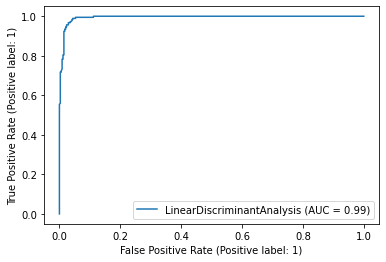

In [92]:
X_feat = ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Mitoses']
        
X = pd_data[X_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=split_seed)

model = LDA(store_covariance=True)
model.fit(X_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Train recall:", recall_score(y_train, model.predict(X_train)))
_ = RocCurveDisplay.from_estimator(model, X_train, y_train)

Test accuracy: 0.92
Test recall: 0.7719298245614035


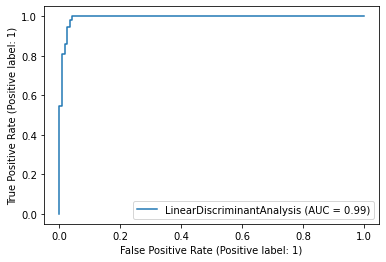

In [93]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_test)))
print("Test recall:", recall_score(y_test, model.predict(X_test)))
_ = RocCurveDisplay.from_estimator(model, X_test, y_test)

Sensitivity  0.7719298245614035
Specificity  0.9915254237288136
Precision  0.9777777777777777
F1-score 0.8627450980392156 

              precision    recall  f1-score   support

      Benign       0.90      0.99      0.94       118
   Malignant       0.98      0.77      0.86        57

    accuracy                           0.92       175
   macro avg       0.94      0.88      0.90       175
weighted avg       0.93      0.92      0.92       175



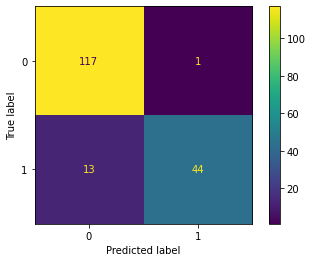

In [94]:
cm = confusion_matrix(y_test, model.predict(X_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_test), target_names=['Benign', 'Malignant']))

Forward Feature Selection does not improve the model in terms of F$1$-score. In fact, selecting those subset of features we end up with very high test specificity but lower sensitivity (test recall and sensitivity are both $0.77$ now). It may not seem reasonable, but we recall Forward Feature Selection is a greedy algorithm, so we have no guarantee that the best possible subset is chosen.

## LDA with polynomial features
As before, we select the best degree according to cross-validation, starting from considering accuracy as metric.

  (best 2) CV accuracy: 0.9599782293178519
  (best 2) Test accuracy: 0.9485714285714286


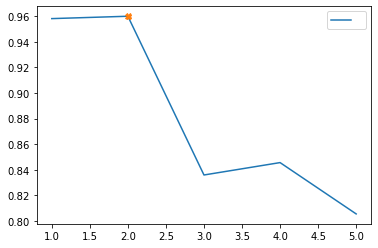

In [95]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy_score))
cv.fit(X_full_train, y_train)

show_results_acc(cv, X_full_test, 'param_poly__degree')

Considering accuracy metric, we obtain that degree $= 2$ is again the best (see next). Degrees $\geq 2$ end up in overfitting.

  (best 2) CV recall: 0.9406432748538011
  (best 2) Test recall: 0.8947368421052632


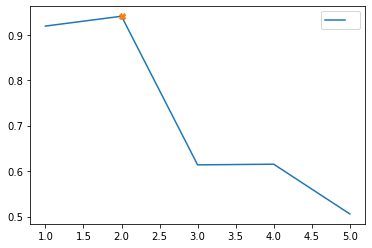

In [96]:
model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(recall_score))
cv.fit(X_full_train, y_train)

show_results_rec(cv, X_full_test, 'param_poly__degree')

The same holds true for considering recall as metric.

Train accuracy: 0.9751908396946565
Train recall: 0.9728260869565217


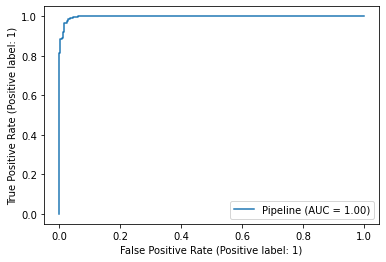

In [97]:
Model_best = cv.best_estimator_

print("Train accuracy:", accuracy_score(y_train, Model_best.predict(X_full_train)))
print("Train recall:", recall_score(y_train, Model_best.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(Model_best, X_full_train, y_train)

Test accuracy: 0.9485714285714286
Test recall: 0.8947368421052632


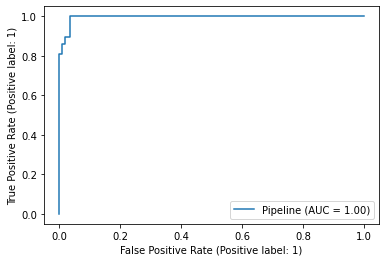

In [98]:
print("Test accuracy:", accuracy_score(y_test, Model_best.predict(X_full_test)))
print("Test recall:", recall_score(y_test, Model_best.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(Model_best, X_full_test, y_test)

Sensitivity  0.8947368421052632
Specificity  0.9745762711864406
Precision  0.9444444444444444
F1-score 0.918918918918919 

              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96       118
   Malignant       0.94      0.89      0.92        57

    accuracy                           0.95       175
   macro avg       0.95      0.93      0.94       175
weighted avg       0.95      0.95      0.95       175



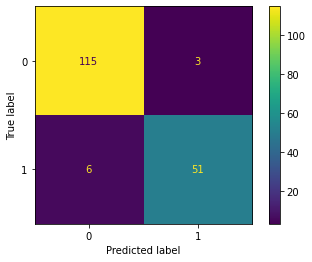

In [99]:
cm = confusion_matrix(y_test, Model_best.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(Model_best, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, Model_best.predict(X_full_test), target_names=['Benign', 'Malignant']))

Results on test set are very similar to LDA with degree $= 1$. In fact, if we look at the first graph showing CV accuracy (same holds for CV recall), we see a very similar CV score between models with degree $1$ and $2$.

# Quadratic Discriminant Analysis
Like LDA, quadratic discriminant analysis classifies data based on their a posteriori probability, which is computed through the Bayes theorem. QDA differs from LDA in the fact that it doesn't assume that all the classes shares the same variance: the data is assumed to be drawn by gaussian distributions with different mean and variance.

Train accuracy: 0.9618320610687023
Train recall: 0.9836956521739131


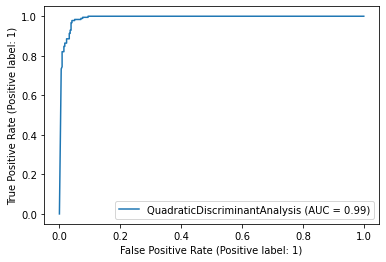

In [100]:
model = QDA(store_covariance=True)
model = model.fit(X_full_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_full_train)))
print("Train recall:", recall_score(y_train, model.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(model, X_full_train, y_train)

Test accuracy: 0.9485714285714286
Test recall: 0.9649122807017544


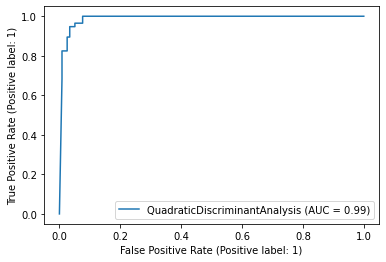

In [101]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_full_test)))
print("Test recall:", recall_score(y_test, model.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(model, X_full_test, y_test)

Sensitivity  0.8947368421052632
Specificity  0.9745762711864406
Precision  0.9444444444444444
F1-score 0.918918918918919 

              precision    recall  f1-score   support

   Malignant       0.98      0.94      0.96       118
      Benign       0.89      0.96      0.92        57

    accuracy                           0.95       175
   macro avg       0.93      0.95      0.94       175
weighted avg       0.95      0.95      0.95       175



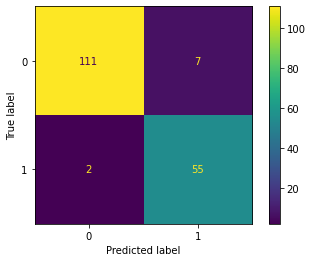

In [102]:
cm = confusion_matrix(y_test, cv.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_full_test), target_names=['Malignant', 'Benign']))

QDA performs very well on this dataset, without ending up in overfitting issue (test scores are really close to train ones). Let's see what happens running Forward Feature Selection.

............
Best model (M1) with 1 features: ['Uniformity_of_cell_shape']
M1 subset score (3.): 0.9294629898403484
............
Best model (M2) with 2 features: ['Uniformity_of_cell_shape', 'Bare_nuclei']
M2 subset score (3.): 0.9464804063860667
............
Best model (M3) with 3 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness']
M3 subset score (3.): 0.9598693759071117
............
Best model (M4) with 4 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Marginal_adhesion']
M4 subset score (3.): 0.9637518142235123
............
Best model (M5) with 5 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Marginal_adhesion', 'Mitoses']
M5 subset score (3.): 0.963788098693759
............
Best model (M6) with 6 features: ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness', 'Marginal_adhesion', 'Mitoses', 'Bland_chromatin']
M6 subset score (3.): 0.9638243831640058
............
Best model (M7) with 7 features: ['Un

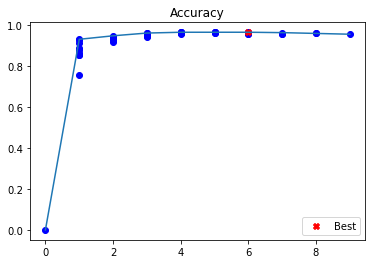

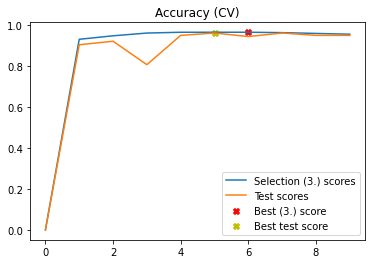

In [103]:
cv = 10

forward_selection(QDA(store_covariance=True),
                  X_full_train, y_train, X_full_test, y_test,
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv)

Train accuracy: 0.9637404580152672
Train recall: 0.9347826086956522


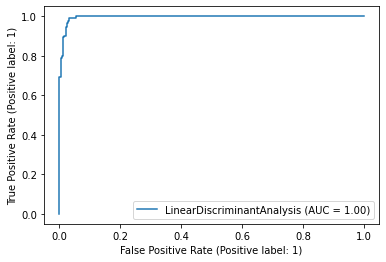

In [104]:
X_feat = ['Uniformity_of_cell_shape', 'Bare_nuclei', 'Clump_thickness',
          'Marginal_adhesion', 'Mitoses', 'Bland_chromatin']
        
X = pd_data[X_feat]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=split_seed)

model = LDA(store_covariance=True)
model.fit(X_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Train recall:", recall_score(y_train, model.predict(X_train)))
_ = RocCurveDisplay.from_estimator(model, X_train, y_train)

Test accuracy: 0.9542857142857143
Test recall: 0.8771929824561403


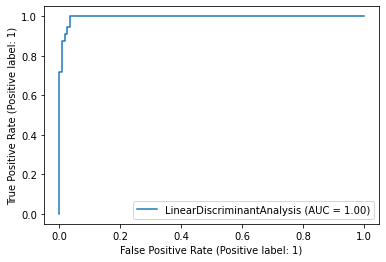

In [105]:
print("Test accuracy:", accuracy_score(y_test, model.predict(X_test)))
print("Test recall:", recall_score(y_test, model.predict(X_test)))
_ = RocCurveDisplay.from_estimator(model, X_test, y_test)

Sensitivity  0.8771929824561403
Specificity  0.9915254237288136
Precision  0.9803921568627451
F1-score 0.9259259259259259 

              precision    recall  f1-score   support

      Benign       0.94      0.99      0.97       118
   Malignant       0.98      0.88      0.93        57

    accuracy                           0.95       175
   macro avg       0.96      0.93      0.95       175
weighted avg       0.96      0.95      0.95       175



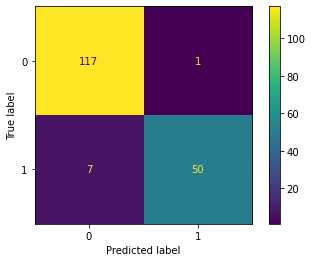

In [106]:
cm = confusion_matrix(y_test, model.predict(X_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, model.predict(X_test), target_names=['Benign', 'Malignant']))

Using Forward Feature Selection on QDA we reached an almost perfect specificity ($0.99$) loosing a bit of sensitivity with respect to full model.

# K-Nearest Neighbors

KNN is a non-parametric model used to approximate the Bayes Classifier. The algorithm is very simple:
- the training phase only consists in storing the training dataset
- at prediction, given a query point to classify, we identify the $K$ closest training points and predict as class the most frequent class among the selected neighbors.

## Hyperparameters selection

As usual we can use grid search and cross validation to select the best $K$ for the dataset. In this case:
- a large value of $K$ results in a smoother boundary
- a small value of $K$ in a more complex model

### Does feature normalization matter?

KNN relies on sample distances to perform prediction. In most cases, having normalized features that all span on the same range allow samples to be compared more reliably.

We usually have two options for normalizing features:
- range normalization: $x' = \frac{x - x_{min}}{x_{max} - x_{min}}$ which makes all the features have values between $[0, 1]$
- z-score normalization: $x' = \frac{x - \mu}{\sigma}$ which make feature have 0 mean and unitary variance

Let's try both and check how the cross validation accuracy and recall change.

 Unnormalized (best 9) CV accuracy: 0.9695210449927429
 Unnormalized (best 9) Test accuracy: 0.9714285714285714
 StandardScaler (best 15) CV accuracy: 0.9694847605224963
 StandardScaler (best 15) Test accuracy: 0.9657142857142857
 MinMaxScaler (best 7) CV accuracy: 0.9676342525399129
 MinMaxScaler (best 7) Test accuracy: 0.9657142857142857


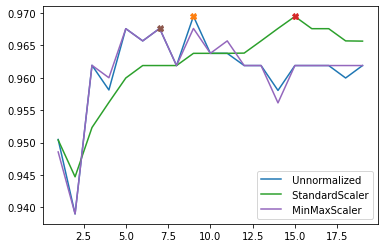

In [107]:
model = KNeighborsClassifier()
params = {'n_neighbors': range(1, 20)}
scorer = make_scorer(accuracy_score)

cv = GridSearchCV(model,params,cv=10,scoring=scorer)
cv.fit(X_full_train, y_train)

params = {'knn__n_neighbors': range(1, 20)}
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())])
cv_std = GridSearchCV(model_std, params, refit=True, cv=10,
                     scoring=make_scorer(accuracy_score))
cv_std.fit(X_full_train, y_train)

model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())])
cv_minmax = GridSearchCV(model_minmax, params, refit=True, cv=10,
                        scoring=make_scorer(accuracy_score))
cv_minmax.fit(X_full_train, y_train)

# Plot the cv lines
show_results_acc(cv, X_full_test, "param_n_neighbors", prefix="Unnormalized")
show_results_acc(cv_std, X_full_test, 'param_knn__n_neighbors', "StandardScaler")
show_results_acc(cv_minmax, X_full_test, 'param_knn__n_neighbors', "MinMaxScaler")

Train accuracy: 0.9732824427480916
Train recall: 0.9728260869565217


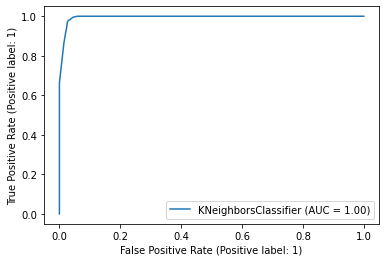

In [108]:
Model_best = cv.best_estimator_

print("Train accuracy:", accuracy_score(y_train, Model_best.predict(X_full_train)))
print("Train recall:", recall_score(y_train, Model_best.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(Model_best, X_full_train, y_train)

Test accuracy: 0.9714285714285714
Test recall: 0.9473684210526315


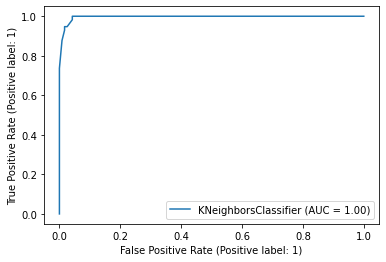

In [109]:
print("Test accuracy:", accuracy_score(y_test, Model_best.predict(X_full_test)))
print("Test recall:", recall_score(y_test, Model_best.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(Model_best, X_full_test, y_test)

Sensitivity  0.9473684210526315
Specificity  0.9830508474576272
Precision  0.9642857142857143
F1-score 0.9557522123893805 

              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       118
   Malignant       0.96      0.95      0.96        57

    accuracy                           0.97       175
   macro avg       0.97      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175



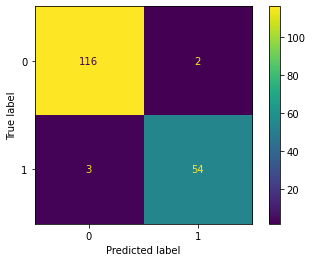

In [110]:
cm = confusion_matrix(y_test, Model_best.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(Model_best, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, Model_best.predict(X_full_test), target_names=['Benign', 'Malignant']))

Unnormalized KNN with $K = 9$ performs brilliant on our dataset, ending up in a F$1$-score of $0.96$ (the highest until now).

Same $K$s are found considering recall as metric:

 Unnormalized (best 9) CV recall: 0.962280701754386
 Unnormalized (best 9) Test recall: 0.9473684210526315
 StandardScaler (best 15) CV recall: 0.9675438596491228
 StandardScaler (best 15) Test recall: 0.9473684210526315
 MinMaxScaler (best 7) CV recall: 0.9570175438596491
 MinMaxScaler (best 7) Test recall: 0.9298245614035088


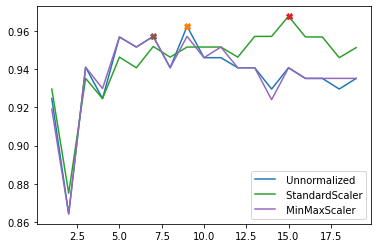

In [111]:
params = {'n_neighbors': range(1, 20)}
scorer = make_scorer(recall_score)

cv = GridSearchCV(model,params,cv=10,scoring=scorer)
cv.fit(X_full_train, y_train)

params = {'knn__n_neighbors': range(1, 20)}
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())])
cv_std = GridSearchCV(model_std, params, refit=True, cv=10,
                     scoring=make_scorer(recall_score))
cv_std.fit(X_full_train, y_train)

model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())])
cv_minmax = GridSearchCV(model_minmax, params, refit=True, cv=10,
                        scoring=make_scorer(recall_score))
cv_minmax.fit(X_full_train, y_train)

# Plot the cv lines
show_results_rec(cv, X_full_test, "param_n_neighbors", prefix="Unnormalized")
show_results_rec(cv_std, X_full_test, 'param_knn__n_neighbors', "StandardScaler")
show_results_rec(cv_minmax, X_full_test, 'param_knn__n_neighbors', "MinMaxScaler")

<i>Unnormalized</i> KNN with $K = 9$ is the one with the best CV and test accuracy score. <i>StandardScaler</i> KNN with $K = 15$ is the one with the best CV and test recall score (actually, test recall is identical to <i>Unnormalized</i> KNN with $K = 9$). We have to say that <i>Unnormalized</i>, <i>StandardScaler</i> and <i>MinMaxScaler</i> scores are all really close to one, so all of them are a good choice for this specific dataset.

Train accuracy: 0.9694656488549618
Train recall: 0.9619565217391305


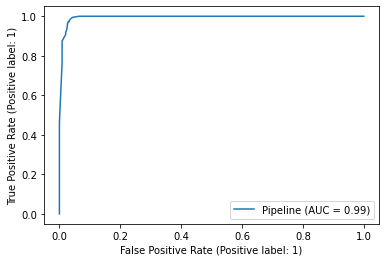

In [112]:
Model_best = cv_std.best_estimator_

print("Train accuracy:", accuracy_score(y_train, Model_best.predict(X_full_train)))
print("Train recall:", recall_score(y_train, Model_best.predict(X_full_train)))
_ = RocCurveDisplay.from_estimator(Model_best, X_full_train, y_train)

Test accuracy: 0.9657142857142857
Test recall: 0.9473684210526315


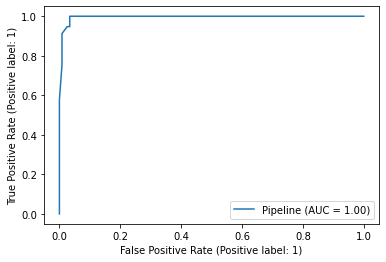

In [113]:
print("Test accuracy:", accuracy_score(y_test, Model_best.predict(X_full_test)))
print("Test recall:", recall_score(y_test, Model_best.predict(X_full_test)))
_ = RocCurveDisplay.from_estimator(Model_best, X_full_test, y_test)

Sensitivity  0.9473684210526315
Specificity  0.9745762711864406
Precision  0.9473684210526315
F1-score 0.9473684210526315 

              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       118
   Malignant       0.95      0.95      0.95        57

    accuracy                           0.97       175
   macro avg       0.96      0.96      0.96       175
weighted avg       0.97      0.97      0.97       175



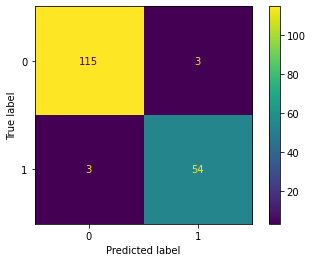

In [114]:
cm = confusion_matrix(y_test, Model_best.predict(X_full_test))
# Plot test confution matrix
_ = ConfusionMatrixDisplay.from_estimator(Model_best, X_full_test, y_test)

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm), "\n")

print(classification_report(y_test, Model_best.predict(X_full_test), target_names=['Benign', 'Malignant']))

# Support Vector Machine

Support vector machine is a classification method that finds an hyperplane that divides the data in the features' space by maximizing the margin between the decision boundary and the samples, possibly taking into account also misclassified points. The cost to penalize points that are misclassified, $C$, needs to be optimized for the specific dataset.

SVM can use different <b>kernel functions</b> to find the best hyperplane in another space and then project it in the feature space, obtaining a non-linear boundary.

## Grid Search for the best Kernel

We will take into account:

- <b>Linear</b>

- <b>RBF</b> (Radial Basis Function) Kernel:  $K\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\exp \left(-\gamma\left\|\boldsymbol{x}-\boldsymbol{x}^{\prime}\right\|^{2}\right)\quad$ where $\gamma$ is specified by parameter `gamma`, must be greater than 0

- <b>Polynomial</b> Kernel: $K\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\left(\gamma\left\langle x, x^{\prime}\right\rangle+r\right)^{d}\quad$ where $d$ is specified by parameter `degree`, $r$ by `coef0`

- <b>Sigmoid</b> Kernel: $K\left(\mathbf{x}, \mathbf{x}^{\prime}\right) = \tanh \left(\gamma\left\langle x, x^{\prime}\right\rangle+r\right)\quad$ where $r$ is specified by `coef0`, $\gamma$ is specified by parameter `gamma`

First we will consider accuracy as metric.

In [115]:
# Linear
param_grid = {'C':np.linspace(0.001, 100, 5)}
svm_model = SVC(kernel='linear')
svm_linear = GridSearchCV(SVC(kernel='linear'), param_grid,
                         cv=5, scoring='accuracy', refit=True)
svm_linear.fit(X_full_train, y_train)

# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='accuracy', refit=True)
svm_poly.fit(X_full_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='accuracy', refit=True)
rbf_poly.fit(X_full_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='accuracy', refit=True)
sigm_poly.fit(X_full_train, y_train)

for m in [svm_linear, svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    print("cv score: {}\n".format(cv_score))

SVC(C=25.00075, kernel='linear')
cv score: 0.9618315018315018

SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
cv score: 0.9618131868131868

SVC(C=25.00075, gamma=0.001)
cv score: 0.9656410256410256

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
cv score: 0.9656410256410256



SVC(C=25.00075, kernel='linear')
train accuracy: 0.9713740458015268
train recall: 0.967391304347826

SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
train accuracy: 0.9732824427480916
train recall: 0.967391304347826

SVC(C=25.00075, gamma=0.001)
train accuracy: 0.9732824427480916
train recall: 0.9728260869565217

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
train accuracy: 0.9732824427480916
train recall: 0.9728260869565217



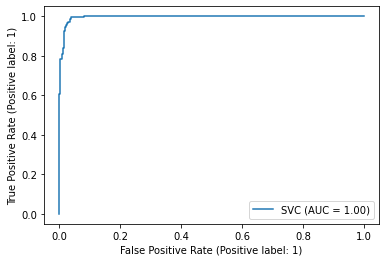

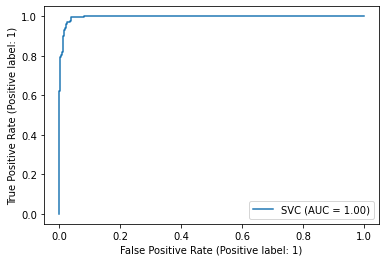

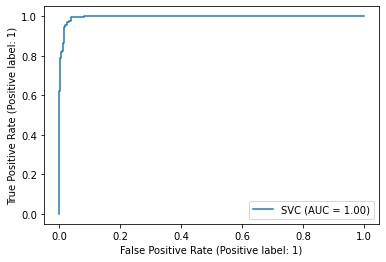

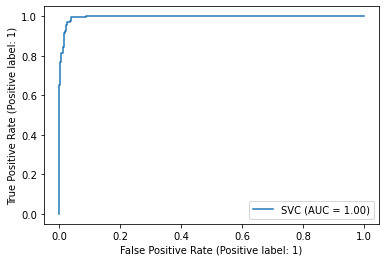

In [116]:
for m in [svm_linear, svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    print("train accuracy: {}".format(accuracy_score(y_train, m.predict(X_full_train))))
    print("train recall: {}\n".format(recall_score(y_train, m.predict(X_full_train))))
    _ = RocCurveDisplay.from_estimator(m, X_full_train, y_train)

SVC(C=25.00075, kernel='linear')
test accuracy: 0.9657142857142857
test recall: 0.9298245614035088

SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
test accuracy: 0.96
test recall: 0.9122807017543859

SVC(C=25.00075, gamma=0.001)
test accuracy: 0.9657142857142857
test recall: 0.9298245614035088

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
test accuracy: 0.9657142857142857
test recall: 0.9298245614035088



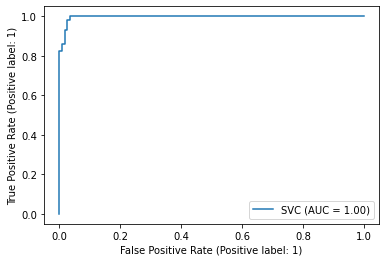

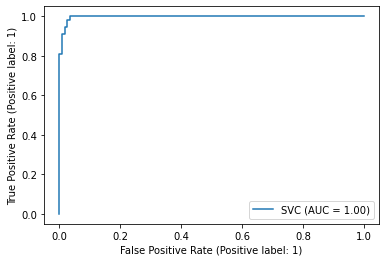

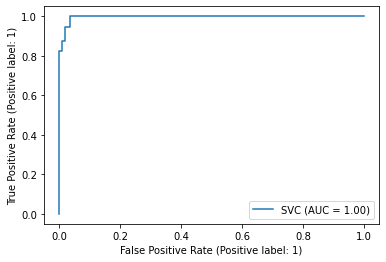

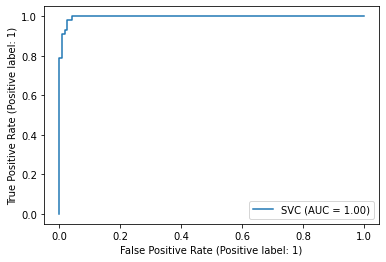

In [117]:
for m in [svm_linear, svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    test_acc = accuracy_score(y_test, m.predict(X_full_test))
    print("test accuracy: {}".format(accuracy_score(y_test, m.predict(X_full_test))))
    print("test recall: {}\n".format(recall_score(y_test, m.predict(X_full_test))))
    _ = RocCurveDisplay.from_estimator(m, X_full_test, y_test)

All kernels have a CV score close to $1$ with RBF and sigmoid (<i>SVC(C=25.00075, gamma=0.001, kernel='sigmoid')</i>) performing best. Let's now see what happens considering recall as metric.

In [118]:
#Linear
param_grid = {'C':np.linspace(0.001, 100, 5)}
svm_model = SVC(kernel='linear')
svm_linear = GridSearchCV(SVC(kernel='linear'), param_grid,
                         cv=5, scoring='recall', refit=True)
svm_linear.fit(X_full_train, y_train)

# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='recall', refit=True)
svm_poly.fit(X_full_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='recall', refit=True)
rbf_poly.fit(X_full_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='recall', refit=True)
sigm_poly.fit(X_full_train, y_train)

for m in [svm_linear, svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    print("cv score: {}\n".format(cv_score))

SVC(C=25.00075, kernel='linear')
cv score: 0.9513513513513514

SVC(C=0.001, coef0=-10.0, kernel='poly')
cv score: 0.9728228228228228

SVC(C=25.00075, gamma=0.001)
cv score: 0.9567567567567569

SVC(C=50.000499999999995, gamma=0.001, kernel='sigmoid')
cv score: 0.9621621621621621



SVC(C=25.00075, kernel='linear')
train accuracy: 0.9713740458015268
train recall: 0.967391304347826

SVC(C=0.001, coef0=-10.0, kernel='poly')
train accuracy: 0.9618320610687023
train recall: 0.9782608695652174

SVC(C=25.00075, gamma=0.001)
train accuracy: 0.9732824427480916
train recall: 0.9728260869565217

SVC(C=50.000499999999995, gamma=0.001, kernel='sigmoid')
train accuracy: 0.9732824427480916
train recall: 0.9728260869565217



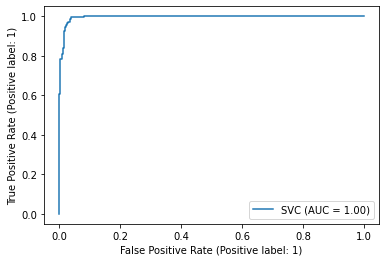

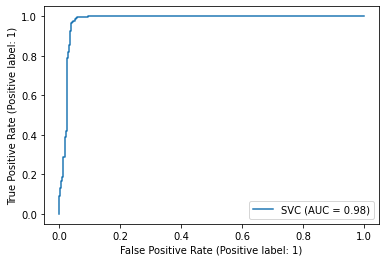

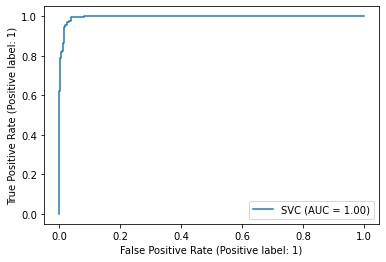

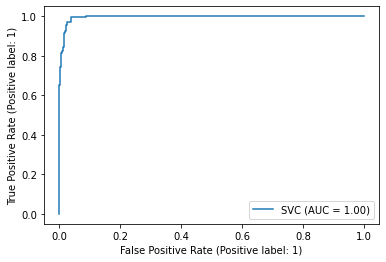

In [119]:
for m in [svm_linear, svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    print("train accuracy: {}".format(accuracy_score(y_train, m.predict(X_full_train))))
    print("train recall: {}\n".format(recall_score(y_train, m.predict(X_full_train))))
    _ = RocCurveDisplay.from_estimator(m, X_full_train, y_train)

SVC(C=25.00075, kernel='linear')
test accuracy: 0.9657142857142857
test recall: 0.9298245614035088

SVC(C=0.001, coef0=-10.0, kernel='poly')
test accuracy: 0.9485714285714286
test recall: 0.9122807017543859

SVC(C=25.00075, gamma=0.001)
test accuracy: 0.9657142857142857
test recall: 0.9298245614035088

SVC(C=50.000499999999995, gamma=0.001, kernel='sigmoid')
test accuracy: 0.9657142857142857
test recall: 0.9298245614035088



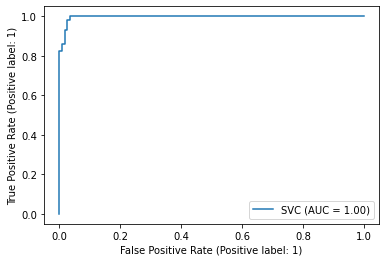

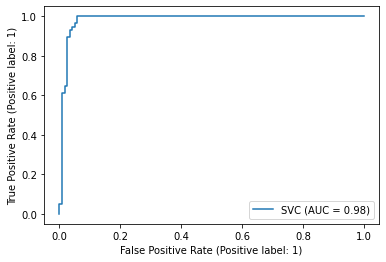

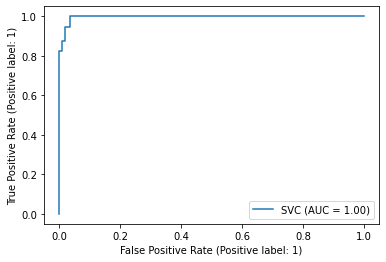

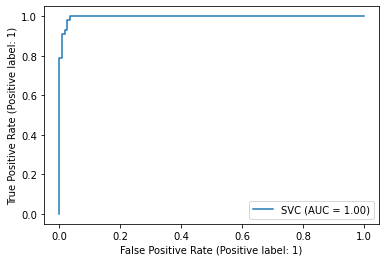

In [120]:
for m in [svm_linear, svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    test_acc = accuracy_score(y_test, m.predict(X_full_test))
    print("test accuracy: {}".format(accuracy_score(y_test, m.predict(X_full_test))))
    print("test recall: {}\n".format(recall_score(y_test, m.predict(X_full_test))))
    _ = RocCurveDisplay.from_estimator(m, X_full_test, y_test)

This time, <i>SVC(C=0.001, coef0=-10.0, kernel='poly')</i> has the highest CV score although, as before, all kernels have a CV score close to $1$.

# Final comparison and considerations
Finally, let's compare all the models seen until now using the full set of features. As done before, we take into account accuracy and then recall metrics.

logistic CV score: 0.9619,  test score 0.9543
lasso CV score: 0.9676,  test score 0.9486
ridge CV score: 0.9714,  test score 0.9657
logistic_poly CV score: 0.9411,  test score 0.9086
perceptron CV score: 0.9370,  test score 0.9314
lda CV score: 0.9581,  test score 0.9543
lda_poly CV score: 0.9600,  test score 0.9486
qda CV score: 0.9542,  test score 0.9486
SVC_sigmoid CV score: 0.9656,  test score 0.9657
KNN (K=9) CV score: 0.9695,  test score 0.9714
KNN_std (K=15) CV score: 0.9695,  test score 0.9657
KNN_minmax (K=7) CV score: 0.9676,  test score 0.9657


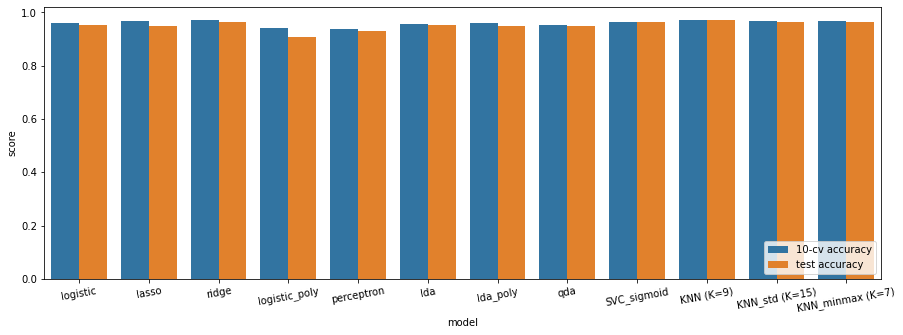

In [121]:
logistic = LogisticRegression(solver='newton-cg', penalty='none') 
lasso = Pipeline([('scaler',preprocessing.StandardScaler()), 
                 ('classifier',LogisticRegression(solver='liblinear', penalty='l1', C=0.030396969696969697))])
ridge_5 = Pipeline([('scaler',preprocessing.StandardScaler()), 
                 ('classifier',LogisticRegression(solver='liblinear', penalty='l2', C=0.00514949494949495))])
pt_model = Perceptron()
lr_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('lda', LogisticRegression(solver='newton-cg'))])
lda = LDA(store_covariance=True)
lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA(store_covariance=True))])
qda = QDA(store_covariance=True)
svc_sigmoid= SVC(C=25.00075, gamma=0.001, kernel='sigmoid', probability=True)
knn = KNeighborsClassifier(n_neighbors=9)
knn_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15))]) 
knn_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7))]) 

models = OrderedDict([('logistic', logistic), ('lasso', lasso), ('ridge', ridge_5), ('logistic_poly', lr_poly),
                      ('perceptron', pt_model), ('lda', lda), ('lda_poly', lda_poly), ('qda', qda),
                      ('SVC_sigmoid', svc_sigmoid), ('KNN (K=9)', knn),
                      ('KNN_std (K=15)', knn_std), ('KNN_minmax (K=7)', knn_minmax)])

cv_scores, test_scores = [], []
for name, model in models.items():
    scores = cross_val_score(model,X_full_train,y_train,cv=10,scoring=make_scorer(accuracy_score))
    cv_score = scores.mean()
    cv_scores.append(cv_score)
    
    model.fit(X_full_train, y_train)
    test_score = accuracy_score(y_test, model.predict(X_full_test))
    test_scores.append(test_score)
    print("{} CV score: {:.4f},  test score {:.4f}".format(name, cv_score, test_score))

data = pd.DataFrame()
data['model'] = list(models.keys()) * 2
data['metric'] = ['10-cv accuracy'] * len(cv_scores) + ['test accuracy'] * len(test_scores)
data['score'] = cv_scores + test_scores

plt.figure(figsize=(15,5))
_ = sns.barplot(x='model', y='score', data=data, hue='metric')
_ = plt.legend(loc='lower right')
_ = plt.xticks(rotation = 10) # X axis' rotation = 10°

Highest results in terms of $10$-CV and test accuracy scores are reached by Ridge Regression (CV score: $0.9714$,  test score $0.9657$) and Unnormalized KNN with $K = 9$ (CV score: $0.9695$,  test score $0.9714$).

Let's now consider recall.

logistic CV score: 0.9406,  test score 0.8947
lasso CV score: 0.9515,  test score 0.9123
ridge CV score: 0.9728,  test score 0.9474
logistic_poly CV score: 0.9041,  test score 0.7544
perceptron CV score: 0.9623,  test score 1.0000
lda CV score: 0.9190,  test score 0.8947
lda_poly CV score: 0.9406,  test score 0.8947
qda CV score: 0.9839,  test score 0.9649
SVC_poly CV score: 0.9787,  test score 0.9123
KNN (K=9) CV score: 0.9623,  test score 0.9474
KNN_std (K=15) CV score: 0.9675,  test score 0.9474
KNN_minmax (K=7) CV score: 0.9570,  test score 0.9298


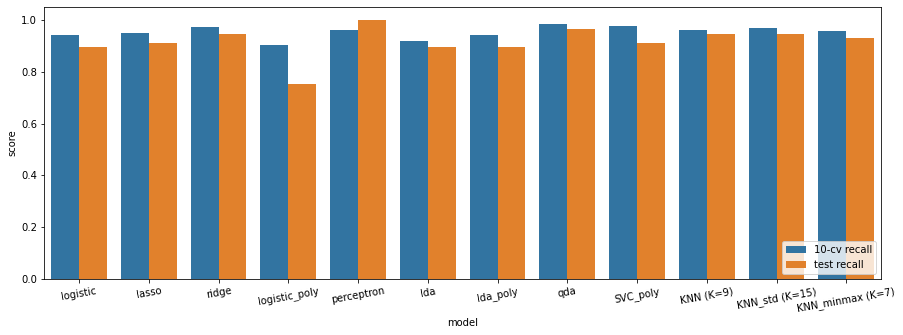

In [122]:
ridge_1 = Pipeline([('scaler',preprocessing.StandardScaler()), 
                 ('classifier',LogisticRegression(solver='liblinear', penalty='l2', C=0.0001))])
svc_poly = SVC(C=0.001, coef0=-10.0, kernel='poly', probability=True)

models = OrderedDict([('logistic', logistic), ('lasso', lasso), ('ridge', ridge_1), ('logistic_poly', lr_poly),
                      ('perceptron', pt_model), ('lda', lda), ('lda_poly', lda_poly), ('qda', qda),
                      ('SVC_poly', svc_poly), ('KNN (K=9)', knn),
                      ('KNN_std (K=15)', knn_std), ('KNN_minmax (K=7)', knn_minmax)])

cv_scores, test_scores = [], []
for name, model in models.items():
    scores = cross_val_score(model,X_full_train,y_train,cv=10,scoring=make_scorer(recall_score))
    cv_score = scores.mean()
    cv_scores.append(cv_score)
    
    model.fit(X_full_train, y_train)
    test_score = recall_score(y_test, model.predict(X_full_test))
    test_scores.append(test_score)
    print("{} CV score: {:.4f},  test score {:.4f}".format(name, cv_score, test_score))

data = pd.DataFrame()
data['model'] = list(models.keys()) * 2
data['metric'] = ['10-cv recall'] * len(cv_scores) + ['test recall'] * len(test_scores)
data['score'] = cv_scores + test_scores

plt.figure(figsize=(15,5))
_ = sns.barplot(x='model', y='score', data=data, hue='metric')
_ = plt.legend(loc='lower right')
_ = plt.xticks(rotation = 10) # X axis' rotation = 10°

Even though we did not give too much attention to it, <b>Perceptron</b> performs very well on this dataset if we are interested in considering recall as metric (Perceptron CV score: $0.9623$, test score $1.0000$). Basically a Perceptron is a linear classifier for which we do not assume any particular probabilistic model generating the data (we learn the parameters using some optimization technique so to minimize an error function, e.g., the error rate).

Beside Perceptron, highest performances in terms of recall are reached by Ridge Regression (CV score: $0.9728$, test score $0.9474$) and QDA (CV score: $0.9839$, test score $0.9649$).

Polynomial Logistic Regression with a degree of $2$ ends up in a low test score (logistic_poly CV score: $0.9041$, test score $0.7544$</i>), so we are suspicious of <b>overfitting</b> (see next).

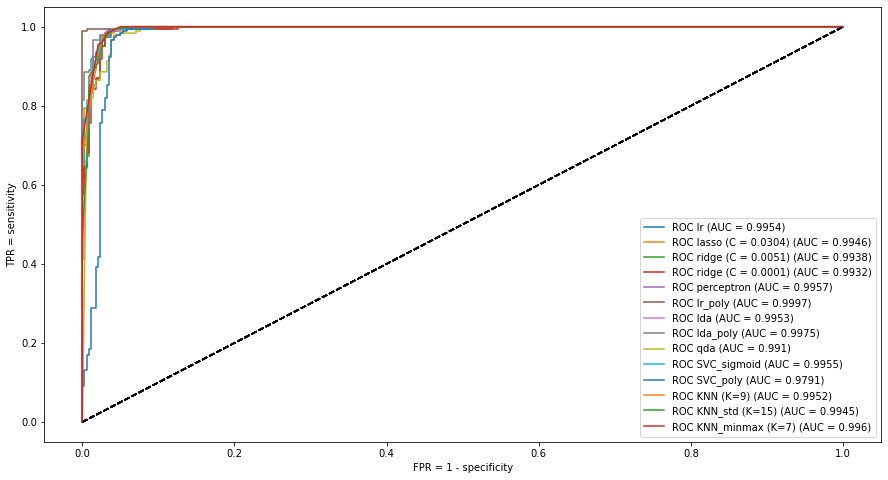

In [123]:
def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, _ = roc_curve(y, predict_fn(X)[:,-1])
    auc = roc_auc_score(y, predict_fn(X)[:,-1])
    plt.plot(fprs, tprs, label="ROC " + label + " (AUC = " + (np.round(auc,4)).astype('str') + ')')
    x_r = y_r = [0,1]
    plt.plot(x_r, x_r, color = 'black', linestyle='--')
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()

clf_isotonic = CalibratedClassifierCV(pt_model, cv=10, method='isotonic')

plt.figure(figsize=(15,8))
for name, model in [('lr', logistic), 
                    ('lasso (C = 0.0304)', lasso),
                    ('ridge (C = 0.0051)', ridge_5),
                    ('ridge (C = 0.0001)', ridge_1),
                    ('perceptron', clf_isotonic),
                    ('lr_poly', lr_poly), 
                    ('lda', lda), 
                    ('lda_poly', lda_poly), 
                    ('qda', qda),
                    ('SVC_sigmoid', svc_sigmoid),
                    ('SVC_poly', svc_poly),
                    ('KNN (K=9)', knn),
                    ('KNN_std (K=15)', knn_std),
                    ('KNN_minmax (K=7)', knn_minmax)]:
    model.fit(X_full_train, y_train)
    plot_roc(model.predict_proba, X_full_train, y_train, name)

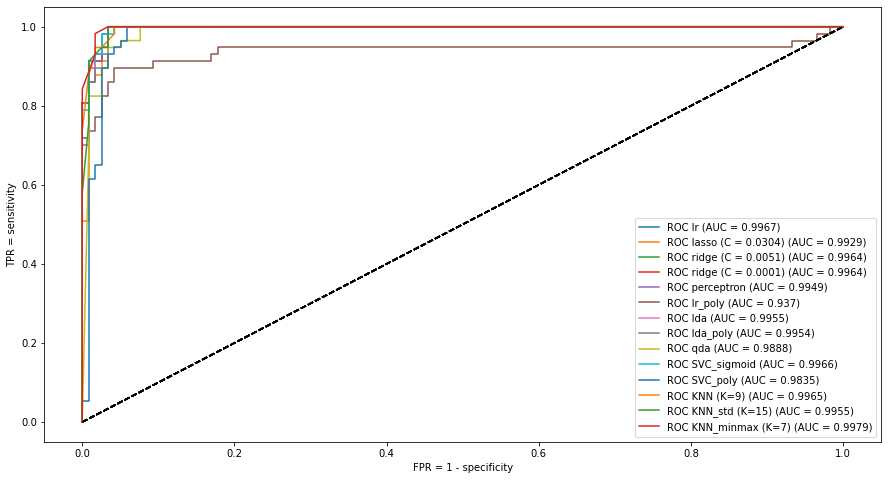

In [124]:
plt.figure(figsize=(15,8))
for name, model in [('lr', logistic), 
                    ('lasso (C = 0.0304)', lasso),
                    ('ridge (C = 0.0051)', ridge_5),
                    ('ridge (C = 0.0001)', ridge_1),
                    ('perceptron', clf_isotonic),
                    ('lr_poly', lr_poly), 
                    ('lda', lda),
                    ('lda_poly', lda_poly), 
                    ('qda', qda),
                    ('SVC_sigmoid', svc_sigmoid),
                    ('SVC_poly', svc_poly),
                    ('KNN (K=9)', knn),
                    ('KNN_std (K=15)', knn_std),
                    ('KNN_minmax (K=7)', knn_minmax)]:
    plot_roc(model.predict_proba, X_full_test, y_test, name)

All models performs very well on test set except one: what is interesting to re-discuss here is the overfitting issue appeared applying a polynomial Logistic Regression model on this dataset. Performance on train set are very high (with the highest train AUC among all models), but we have lowest test set performance (lowest test AUC among all models).

The best test AUC is given by MinMax KNN with $K = 7$ (AUC $= 0.9979$), followed by simple (i.e., without any kind of normalization) Logistic Regression (AUC $= 0.9967$) and SVC with a sigmoid kernel (very similar to last mentioned one with AUC $= 0.9966$).